Have you ever been on a trip with your friends for a weekend, and you couldn't help but take care of the hotel situation, being the control freak you are?

You end up finding a good shortlist of offers for prices you can all afford. But you still can't get a hang on which one of those is better. How much time did it take you navigating between their little details and checking the hundreds of their reviews? An hour? A day? A week? You don't want to just go with your gut and disappoint the group after all.

Well, imagine that instead of a fun short weekend, you got a job in a new city and you're gonna have to pick your home for the next months or even years. There is no way you're going with your gut here.

You can say I'm on the same boat right now. Planning to move to Germany in the near future, I can't help but continuously check the rental offers on websites like ImmobilienScout24, eBay – Kleinanzeigen, and Immowelt.de, which all combined offer thousands of different deals.

If that seems tough to manage, these websites are all in German. Not that my german is weak, but I don't think my 2 weeks streak on Duolingo is gonna cut it here. The automatic translation is inaccurate as well, to say the least. Get it together Google.

Given the abundance of choices, the different languages, and the short amount of time and effort i can spare. There is no way I can make a levelheaded decision altogether.

Or, can I?

# German Real Estate Market Data Analysis


The project you're about dive into consists of analyzing the data about a collection of furnished apartment rental offers found online. The rental offers are based in Germany, more specifically, around the area of Cologne, Bonn, and Essen.

The source that I will be gathering my data from is www.zeitwohnen.de. The data listed on this website is unstructured and needs to be scraped, cleaned, and organized before achieving a workable dataset. I chose this website as my source for the following reasons:

- Having a built-in English version.
- Having the most number of rental offers compared to other English websites.
- Centered around the area I'm planning to move into (Cologne, Bonn, and Essen).

By the 7th of October 2020, there were 332 furnished apartments available for rent. The 332 offers are listed over 12 pages.

The aim of the project is to investigate the greatest value lease deals and find the most suitable offer for me.

Let's start by scraping the website!

<img src="Images/2020-10-05.png">

## Data Scraping

### Step by Step Demonstration

The style of this section will be explanatory. We will start first with demonstrating the small steps needed to scrape the contents of one page, and then we will build up to the main loop used to scrape all the pages of the website.

We start by importing all the necessary, and unnecessary libraries.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import geopandas as gpd
import pgeocode
import requests
import re
import json
from IPython.display import IFrame
from bs4 import BeautifulSoup
from mpl_toolkits.basemap import Basemap
%matplotlib inline

Under a loop, we start first by assigning to `url`, the main pages that show the listings for all of Bonn, Cologne and Essen, with no search filters added.

We also assign to `headers`, our user-agent in order to indentify ourselves to the API.

We make a request to access the website using the beautiful library BeautifulSoup, and we receive the HTML content of the 12 pages.

In [2]:
beg = "https://www.zeitwohnen.de/en/search-results/page/"
end = "/?lang=en&object-id=&filter_search_type%5B%5D=&move-in-date=&rooms=&begriff=&max-price-in-euro=&submit=Search+Properties&wpestate_regular_search_nonce=70fdbba295&_wp_http_referer=%2Fen%2F"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'} 

response=[]
for i in range(12):
    url = beg+str(i+1)+end
    response.append(requests.get(url,headers=headers))
    print('Page number '+str(i+1)+' is received.')

Page number 1 is received.
Page number 2 is received.
Page number 3 is received.
Page number 4 is received.
Page number 5 is received.
Page number 6 is received.
Page number 7 is received.
Page number 8 is received.
Page number 9 is received.
Page number 10 is received.
Page number 11 is received.
Page number 12 is received.


Now, Let's start our analysis with the first page stored under `response[0]`.

We received the success status response code, 200. Which indicates that our request has succeeded.

In [3]:
status_code = response[0].status_code
print(status_code)


200


Let's check the metadata of our request.

In [4]:
metadata = response[0].headers
print(metadata)

{'Date': 'Wed, 07 Oct 2020 19:19:55 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Server': 'Apache', 'Link': '<https://www.zeitwohnen.de/wp-json/>; rel="https://api.w.org/", <https://www.zeitwohnen.de/wp-json/wp/v2/pages/18391>; rel="alternate"; type="application/json", <https://www.zeitwohnen.de/en/?p=18391>; rel=shortlink', 'Cache-Control': 'max-age=3600', 'Expires': 'Wed, 07 Oct 2020 20:19:49 GMT', 'Vary': 'Accept-Encoding,User-Agent', 'Content-Encoding': 'gzip'}


Then we make a soup!

In [5]:
parser=BeautifulSoup(response[0].content, "html.parser")

The HTML file is way too long. Let's reduce it to its head component so we can fit something here.

In [6]:
print(parser.find('head'))

<head><meta charset="utf-8"/><meta content="width=device-width, initial-scale=1,user-scalable=no" name="viewport"/><link href="https://www.zeitwohnen.de/xmlrpc.php" rel="pingback"/> <script src="https://www.zeitwohnen.de/wp-content/themes/wpresidence-child/js/jquery-1.10.2.min.js"></script> <link href="https://www.zeitwohnen.de/suchergebnisse/" hreflang="x-default" rel="alternate"/><link href="https://www.zeitwohnen.de/suchergebnisse/" hreflang="de" rel="alternate"/><link href="https://www.zeitwohnen.de/en/search-results/" hreflang="en" rel="alternate"/><link href="https://www.zeitwohnen.de/wp-content/cache/autoptimize/css/autoptimize_ee5ebb638ea21888aa3740554a9b5a47.css" media="all" rel="stylesheet"/><title>Search Results – zeitwohnen.de</title><meta content="Möblierte Wohnungen und möblierte Apartments ✓ Köln, Bonn, Essen ✓ über 2.000 Wohnungen in unserer Datenbank: Besser Wohnen auf Zeit mit ▻ zeitwohnen.de" name="description"><meta content="index, follow, max-snippet:-1, max-image-

After investigating the HTML file for a while, it appears that each rental offer has an ID that is unique and non nullable.

All these IDs fall inside the `div` tag, under the `col-md-12 listing_wrapper property_unit_type1` class. Let's get them using a regex pattern.

In [7]:
html_ids = parser.find_all("div",class_="col-md-12 listing_wrapper property_unit_type1")
ids1 = [str(x) for x in html_ids]
pattern = 'data-listid="(\d+)"'    
ids = [re.search(pattern, x).group(1) for x in ids1]

print(ids)

['196972', '196953', '196902', '196852', '196655', '196632', '196196', '195862', '195784', '195612', '195389', '195324', '194893', '194838', '194820', '194602', '193820', '193660', '193452', '192786', '192653', '192062', '191871', '190491', '190325', '187374', '186330', '186313', '186246', '185297']


It also appears that the information we need falls under two types:
- **Keys** which are the columns we will use in our tables.
- **Values** which are the rows we will fill for each rental offer.

Both of these types fall inside the *span* tag under specific classes that we will discover below. The two problems we have here is that these classes are different for some groups of keys and values and are similar for other groups.

- **To solve the different class names issue** It makes sense here to create a general function to which we can pass the needed classes and receive the keys and values.

- **To solve the similar class names issue** We will have to follow the order in which the related keys and values have been both listed to match them, and separate them from the previous/next keys and values.

The `values_to_list()` function:
    
- Takes the `parser`.
- Takes the unique `index` of the rental offer.
- Takes the `class_` in which you can find the value.
- Returns the `values` of the rental offer as a list.

The `ids_to_list()` function:
    
- Takes the `parser`.
- Takes the unique `index` of the rental offer.
- Takes the `class_` in which you can find the key.
- Returns the `ids` (keys) of the rental offer as a list.

In [8]:
def values_to_list(index, class_,parser):
    div = parser.findAll("div", {"data-listid": index})
    html_values = div[0].find_all("span",class_)
    values = [x.text for x in html_values]
    return values

def ids_to_list(index, class_,parser):
    ids= values_to_list(index, class_,parser)
    ids=list(set(ids))
    return ids

There are 6 types of keys, 4 of them are under the `property_details_type1_id` class. Let's get them first.

In [9]:
for i in ids:
    four_ids = ids_to_list(i,'property_details_type1_id',parser)
    print(four_ids)

['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Vacant until:']
['Shortest rental period:', 'Object-ID:', 'Available from:', 'Va

As you can see here, there is a missing key from one of the offers. Which means that this information wasn't listed in the website.

If we can't recognize which key is missing in each rental offers, that will cause a shift in the data cells when we combine them.

In order to solve that, we initialize a correct `sample` of the indexes, and use it to create a `missing` dictionnary that stores as a key and value the following:

- **key** the index of the row with the missing column
- **value** the missing column.

We will use the `missing` dictionnary to fix this issue, once we create our dataset.

In [10]:
missing={}
idx =0
sample = ['Available from:','Vacant until:', 'Shortest rental period:', 'Object-ID:']

for i in ids:
    four_ids = ids_to_list(i,'property_details_type1_id',parser)
    if len(four_ids)!=4:
        missing[idx]= list(set(sample) - set(four_ids))
    idx +=1

print(missing)

{27: ['Shortest rental period:']}


The 2 other keys from the total 6 are related to Rooms and Size.
They are respectively listed under the classes `property_details_type1_rooms` and `property_details_type1_size`.

In [11]:
for i in ids:
    rooms = ids_to_list(i,'property_details_type1_rooms',parser)
    print(rooms)

['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']
['Zimmer:', 'Rooms:']


In [12]:
for i in ids:
    size = ids_to_list(i,'property_details_type1_size',parser)
    print(size)

['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']
['Size:', 'Größe:']


We can notice that there are two kinds of translations being listed in the website which creates a problem of redundancy.

Unless we resort to natural language processing, we can't automtically detect and delete the German words, like "Zimmer", that only include regular Latin alphabets.

Since there is only one attribute to be deleted anyway, and unlike the past 4 keys, these 2 keys are not nullable (phew!), we can manually set the rooms and size keys.

In [13]:
rooms.remove("Zimmer:")
print(rooms)
size.remove("Größe:")
print(size)

['Rooms:']
['Size:']


Unlike the keys, the values are all listed under the class `property_details_type1_value` which makes our life a little bit easier. That comes with a cost though, we get the same issues we got before. The null values that can not be identified.

As it will be really cumbersome to try and identify each missing value by analyzing the row's content , we will suffice by appending `NULL` to the end of the rows and try to fix the problem, later, when we merge the lists into datasets.

This technique ensures that there will be no shift in the data cells, since we always keep the same length of rows, by appening `NULL` values.

In [14]:
values_list=[]
for i in ids:
    values = values_to_list(i,'property_details_type1_value',parser)
    if len(values)!=6:
        for j in range(6-len(values)):
            values.append('NULL')
    print(values)
    values_list.append(values)

['1', '26,00 m2', 'immediately', 'Not limited', '3\xa0Mon.', '18416']
['1', '25,00 m2', 'immediately', 'Not limited', '3\xa0Mon.', '18414']
['1', '28,00 m2', '20.10.2020', 'Not limited', '3\xa0Mon.', '18856']
['3', '75,00 m2', '01.07.2021', 'Not limited', '3\xa0Mon.', '18394']
['1', '35,00 m2', 'immediately', 'Not limited', '3\xa0Mon.', '18507']
['2', '55,00 m2', '01.11.2020', 'Not limited', '3\xa0Mon.', '17460']
['1', '30,00 m2', '01.11.2020', 'Not limited', '3\xa0Mon.', '13003']
['2', '37,00 m2', '01.12.2020', 'Not limited', '3\xa0Mon.', '18567']
['1', '35,00 m2', 'immediately', 'Not limited', '3\xa0Mon.', '81068']
['1', '34,00 m2', 'immediately', 'Not limited', '3\xa0Mon.', '19172']
['1', '45,00 m2', '01.11.2020', 'Not limited', '3\xa0Mon.', '18518']
['3', '68,00 m2', '01.11.2020', 'Not limited', '3\xa0Mon.', '15829']
['2', '44,00 m2', 'immediately', 'Not limited', '6\xa0Mon.', '17526']
['1', '26,00 m2', 'immediately', 'Not limited', '2\xa0Mon.', '11561']
['2', '91,00 m2', '01.02.20

After well ordering and merging all the keys, and preparing all the values. It seems that the number of values is a multiple of the number of keys, which makes sense, that means we are on the right way.

In [15]:
keys = rooms + size + sample
print(len(keys))
print(len(values_list))

6
30


Let's check out our data set so far.

In [16]:
df1 = pd.DataFrame(values_list, columns=keys)

In [17]:
df1

,Rooms:,Size:,Available from:,Vacant until:,Shortest rental period:,Object-ID:
0,1,"26,00 m2",immediately,Not limited,3 Mon.,18416
1,1,"25,00 m2",immediately,Not limited,3 Mon.,18414
2,1,"28,00 m2",20.10.2020,Not limited,3 Mon.,18856
3,3,"75,00 m2",01.07.2021,Not limited,3 Mon.,18394
4,1,"35,00 m2",immediately,Not limited,3 Mon.,18507
5,2,"55,00 m2",01.11.2020,Not limited,3 Mon.,17460
6,1,"30,00 m2",01.11.2020,Not limited,3 Mon.,13003
7,2,"37,00 m2",01.12.2020,Not limited,3 Mon.,18567
8,1,"35,00 m2",immediately,Not limited,3 Mon.,81068
9,1,"34,00 m2",immediately,Not limited,3 Mon.,19172


Notice the `NULL` value at the end of the row 23. Athough the cells haven't been shifted as we hoped. The values order isn't correct.

Let's create a function that takes the missing dictionary and brings the missing values to their assigned columns.

The `fix_missing()` function:
    
- Takes the dataset `df`.
- Takes the dictionary `missing`.
- Returns the dataset `df` with the correct order of values.

In [18]:
def fix_missing(df, missing):
    k=0
    for i in missing:
        cols = missing[i]
        for col in cols:
            k+=1
            temp=df[col][i]
            df[col][i]=np.nan
            df.iloc[i,-k]=temp
    return df

Now we have a pretty table!

In [19]:
df1 = fix_missing(df1, missing)
df1

,Rooms:,Size:,Available from:,Vacant until:,Shortest rental period:,Object-ID:
0,1,"26,00 m2",immediately,Not limited,3 Mon.,18416
1,1,"25,00 m2",immediately,Not limited,3 Mon.,18414
2,1,"28,00 m2",20.10.2020,Not limited,3 Mon.,18856
3,3,"75,00 m2",01.07.2021,Not limited,3 Mon.,18394
4,1,"35,00 m2",immediately,Not limited,3 Mon.,18507
5,2,"55,00 m2",01.11.2020,Not limited,3 Mon.,17460
6,1,"30,00 m2",01.11.2020,Not limited,3 Mon.,13003
7,2,"37,00 m2",01.12.2020,Not limited,3 Mon.,18567
8,1,"35,00 m2",immediately,Not limited,3 Mon.,81068
9,1,"34,00 m2",immediately,Not limited,3 Mon.,19172


Although it is pretty, we won't be able to do much analysis from 6 columns. Let's dive in the links of the rental offers and include their information as well.

<img src="Images/2020-10-05 (1).png">

<img src="Images/2020-10-05 (2).png">

After checking the links of the rental offers, we can see that there is useful information. Some are short strings, and some are long descriptive paragraphs. Seeing that we have more than 300 entries to analyze it'll be difficult to analyze and visualize the long descripitive paragraphs. Therefore, we will only select the meaningful short strings. Let's get to work!

The `ids_to_links()` function:
    
- Takes the unique `ids` of each rental offer.
- Returns a list of `links` for each rental offer.

In [20]:
def ids_to_links(ids):
    urls_list=[]
    for i in ids:
        urls = values_to_list(i,'property_details_type1_url',parser)
        urls_list.append(urls)
    
    urls_list = [str(x) for x in urls_list]
    pattern = 'URL: (.*)\''    
    links = [re.search(pattern, x).group(1) for x in urls_list]
    return links

links=ids_to_links(ids)
print(links)

['https://www.zeitwohnen.de/en/furnished-apartments-cologne/rental-18416/', 'https://www.zeitwohnen.de/en/furnished-apartments-cologne/rental-18414/', 'https://www.zeitwohnen.de/en/furnished-apartments-cologne/rental-18856/', 'https://www.zeitwohnen.de/en/furnished-apartments-cologne/rental-18394/', 'https://www.zeitwohnen.de/en/furnished-apartments-bonn/rental-18507/', 'https://www.zeitwohnen.de/en/furnished-apartments-cologne/rental-17460/', 'https://www.zeitwohnen.de/en/furnished-apartments-cologne/rental-13003/', 'https://www.zeitwohnen.de/en/furnished-apartments-bonn/rental-18567/', 'https://www.zeitwohnen.de/en/furnished-apartments-bonn/rental-81068/', 'https://www.zeitwohnen.de/en/furnished-apartments-cologne/rental-19172/', 'https://www.zeitwohnen.de/en/furnished-apartments-bonn/rental-18518/', 'https://www.zeitwohnen.de/en/furnished-apartments-cologne/rental-15829/', 'https://www.zeitwohnen.de/en/furnished-apartments-cologne/rental-17526/', 'https://www.zeitwohnen.de/en/furnis

The `scrape()` function:
    
- Takes the `url` of a rental offer.
- Returns the parser `pars` to be used for reading the content.

In [21]:
def scrape(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'} 
    response = requests.get(url,headers=headers)
    pars = BeautifulSoup(response.content, "html.parser")
    return pars

The `values_to_list_link()` function:
    
- Takes the `parser` received.
- Returns a list of `values` containing both the keys and values of the rental offer.

In [22]:
def values_to_list_link(parser):
    class_ = 'listing_detail'
    html_values = parser.find_all("div",class_)
    values = [x.text for x in html_values]
    return values


Let's check our new attributes.

In [23]:
parser = scrape(links[0])
vals = values_to_list_link(parser)
print(vals)

['Zip: 50931', 'City: Cologne', 'Object-ID: 18416', 'Rent: 890 € per month (incl. VAT 5%), plus electricity, incl. heating', 'Property Size: 26,00 m2', 'Rooms: 1', 'Energy index: 98.45 kWh/m²a', 'Energy class: C', 'Shortest rental period: 3\xa0Mon.', 'Floor: 1', 'Number of Floors: 4', 'Max. Number of People: 2', 'Car parking space: n/a', 'Available from: immediately', 'Vacant until: Not limited', 'Final cleaning: Varies depending on effort', 'Deposit: 1-2 monthly rent', 'Object-ID: 18416', ': Rent:', ': per month (incl. VAT 5%), plus electricity, incl. heating', ' Energy Pass Type: Consumption', ' Energy Pass valid until: 13.05.2029', ' Energy Consumption Parameter: 98,45\xa0kWh/(m²*a)', ' Energy Efficiency Class: C', ' Primary Energy Carrier: Gas', ' Energy Pass Year: as from may 2014', ' Energy Pass Type: Consumption', ' Energy Pass valid until: 13.05.2029', ' Energy Consumption Parameter: 98,45\xa0kWh/(m²*a)', ' Energy Efficiency Class: C', ' Primary Energy Carrier: Gas', ' Energy P

The `data_to_df()` function:
    
- Takes the `vals` list of keys and values extracted.
- Returns the row `[row]` and columns `cols` needed for making a dataframe.

In [24]:
def data_to_df(vals):
    cols=[]
    row=[]
    for i in vals:
        if ': ' in i:
            st = i.split(': ')
            if st[0]!="" and st[1]!="":
                cols.append(st[0])
                row.append(st[1])
    return [row], cols

Here is our new dataset from the first rental offer's link:

In [25]:
r, c = data_to_df(vals)
df2 = pd.DataFrame(r, columns=c)
df2

,Zip,City,Object-ID,Rent,Property Size,Rooms,Energy index,Energy class,Shortest rental period,Floor,...,Energy Consumption Parameter,Energy Efficiency Class,Primary Energy Carrier,Energy Pass Year,Energy Pass Type,Energy Pass valid until,Energy Consumption Parameter,Energy Efficiency Class,Primary Energy Carrier,Energy Pass Year
0,50931,Cologne,18416,"890 € per month (incl. VAT 5%), plus electrici...","26,00 m2",1,98.45 kWh/m²a,C,3 Mon.,1,...,"98,45 kWh/(m²*a)",C,Gas,as from may 2014,Consumption,13.05.2029,"98,45 kWh/(m²*a)",C,Gas,as from may 2014


Let's drop the redundant columns!

In [26]:
df2 = df2.T.drop_duplicates().T

Let's see what we will get if we merge the two datasets `df1` from the main page and `df2` from the rental offer's link.

Before that, we have to clean up the columns of `df1` in order to match them with `df2`

The `rename_newdf()` function:
    
- Takes the `df` dataset with columns names ending with ':'.
- Returns the `df` dataset with clean columns.

In [27]:
def rename_newdf(df):
    cols = df.columns
    newcols={}
    for i in cols:
        newi=i.replace(':','')
        newcols[i]=newi
    df.rename(columns = newcols, inplace = True)
    return df

df1 = rename_newdf(df1)
df1

,Rooms,Size,Available from,Vacant until,Shortest rental period,Object-ID
0,1,"26,00 m2",immediately,Not limited,3 Mon.,18416
1,1,"25,00 m2",immediately,Not limited,3 Mon.,18414
2,1,"28,00 m2",20.10.2020,Not limited,3 Mon.,18856
3,3,"75,00 m2",01.07.2021,Not limited,3 Mon.,18394
4,1,"35,00 m2",immediately,Not limited,3 Mon.,18507
5,2,"55,00 m2",01.11.2020,Not limited,3 Mon.,17460
6,1,"30,00 m2",01.11.2020,Not limited,3 Mon.,13003
7,2,"37,00 m2",01.12.2020,Not limited,3 Mon.,18567
8,1,"35,00 m2",immediately,Not limited,3 Mon.,81068
9,1,"34,00 m2",immediately,Not limited,3 Mon.,19172


Since we have the `Object-ID` column with unique non nullable values on both datasets, we can use that to inner merge both tables.

In [28]:
df = pd.merge(left=df1,right=df2, on='Object-ID').T.drop_duplicates().T
display (df)

,Rooms_x,Size,Available from_x,Vacant until_x,Shortest rental period_x,Object-ID,Zip,City,Rent,Energy index,...,Number of Floors,Max. Number of People,Car parking space,Final cleaning,Deposit,Energy Pass Type,Energy Pass valid until,Energy Consumption Parameter,Primary Energy Carrier,Energy Pass Year
0,1,"26,00 m2",immediately,Not limited,3 Mon.,18416,50931,Cologne,"890 € per month (incl. VAT 5%), plus electrici...",98.45 kWh/m²a,...,4,2,n/a,Varies depending on effort,1-2 monthly rent,Consumption,13.05.2029,"98,45 kWh/(m²*a)",Gas,as from may 2014


Now that we added the information of the first link, let's add the 30 other links listed in the 1st page, and repeat the same process again.

In [29]:
finaldf = df.copy()
for i in links[1:]:
    parser = scrape(i)
    vals = values_to_list_link(parser)
    r, c = data_to_df(vals)
    newdf = pd.DataFrame(r, columns=c)
    newdf = newdf.T.drop_duplicates().T
    comdf = pd.merge(left=df1,right=newdf, on='Object-ID').T.drop_duplicates().T
    finaldf = finaldf.append(comdf)

In [30]:
finaldf.head()

,Rooms_x,Size,Available from_x,Vacant until_x,Shortest rental period_x,Object-ID,Zip,City,Rent,Energy index,...,Deposit,Energy Pass Type,Energy Pass valid until,Energy Consumption Parameter,Primary Energy Carrier,Energy Pass Year,Floor,Final Energy Requirement,Energy Consumption Parameter (Heating),Shortest rental period
0,1,"26,00 m2",immediately,Not limited,3 Mon.,18416,50931,Cologne,"890 € per month (incl. VAT 5%), plus electrici...",98.45 kWh/m²a,...,1-2 monthly rent,Consumption,13.05.2029,"98,45 kWh/(m²*a)",Gas,as from may 2014,NaN,NaN,NaN,NaN
0,1,"25,00 m2",immediately,Not limited,3 Mon.,18414,50931,Cologne,"890 € per month (incl. VAT 5%), plus electrici...",98.45 kWh/m²a,...,1-2 Monthly rent,Consumption,13.05.2029,"98,45 kWh/(m²*a)",Gas,as from may 2014,NaN,NaN,NaN,NaN
0,1,"28,00 m2",20.10.2020,Not limited,3 Mon.,18856,50672,Cologne,"930 € per month, incl. electricity, incl. heating",189.00 kWh/m²a,...,1-2 Monthly rents,Consumption,30.09.2021,"189,00 kWh/(m²*a)",Gas,before 2014,4,NaN,NaN,NaN
0,3,"75,00 m2",01.07.2021,Not limited,3 Mon.,18394,50827,Cologne,"1.650 € per month, incl. electricity, incl. he...",211.00 kWh/m²a,...,2 Monthly rents,Demand,30.09.2020,NaN,Gas,before 2014,2,"211,00 kWh/(m²*a)",NaN,NaN
0,1,"35,00 m2",immediately,Not limited,3 Mon.,18507,53121,Bonn,"990 € per month, plus electricity, incl. heating",128.00 kWh/m²a,...,2 Monthly rents,Consumption,30.09.2021,"128,00 kWh/(m²*a)",Gas,before 2014,Ground floor,NaN,NaN,NaN


### Main Loop

Now that we demonstrated how we can have our first page's table ready, let's loop over all the pages using what we learned.

In [31]:
parser=[]
total_ids=[]
soup=[]
finaldf2 = df2.copy()
page=0

for i in response:
    soup.append(BeautifulSoup(i.content, "html.parser"))
    
for i in soup:
    html_ids = i.find_all("div",class_="col-md-12 listing_wrapper property_unit_type1")
    ids1 = [str(x) for x in html_ids]
    pattern = 'data-listid="(\d+)"'    
    ids = [re.search(pattern, x).group(1) for x in ids1]
    total_ids.append(ids)
    
    urls_list=[]
    for j in total_ids[page]:
        urls = values_to_list(j,'property_details_type1_url',i)
        urls_list.append(urls)
    urls_list = [str(x) for x in urls_list]
    pattern = 'URL: (.*)\''    
    links = [re.search(pattern, x).group(1) for x in urls_list]
    count=0
    
    for k in links:
        count+=1
        newparser = scrape(k)
        vals = values_to_list_link(newparser)
        r, c = data_to_df(vals)
        newdf = pd.DataFrame(r, columns=c)
        newdf = newdf.T.drop_duplicates().T
        finaldf2 = finaldf2.append(newdf)
        
    page+=1
    print('Page number '+str(page)+' is processed.')
    
print('Your final dataset is ready!')

Page number 1 is processed.
Page number 2 is processed.
Page number 3 is processed.
Page number 4 is processed.
Page number 5 is processed.
Page number 6 is processed.
Page number 7 is processed.
Page number 8 is processed.
Page number 9 is processed.
Page number 10 is processed.
Page number 11 is processed.
Page number 12 is processed.
Your final dataset is ready!


## Data Storage

Let's have a look at the final dataset.

In [32]:
finaldf2

,Zip,City,Object-ID,Rent,Property Size,Rooms,Energy index,Energy class,Shortest rental period,Number of Floors,...,Floor,Final Energy Requirement,Energy Consumption Parameter (Heating),Year of construction,Energieausweis-Art,Engergieausweis gültig bis,Energieverbrauchskennwert,Primärenergieträger,Energieausweis-Jahrgang,Endenergiebedarf
0,50931,Cologne,18416,"890 € per month (incl. VAT 5%), plus electrici...","26,00 m2",1,98.45 kWh/m²a,C,3 Mon.,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,50931,Cologne,18416,"890 € per month (incl. VAT 5%), plus electrici...","26,00 m2",1,98.45 kWh/m²a,C,3 Mon.,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,50931,Cologne,18414,"890 € per month (incl. VAT 5%), plus electrici...","25,00 m2",1,98.45 kWh/m²a,C,3 Mon.,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,50672,Cologne,18856,"930 € per month, incl. electricity, incl. heating","28,00 m2",1,189.00 kWh/m²a,NaN,3 Mon.,NaN,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,50827,Cologne,18394,"1.650 € per month, incl. electricity, incl. he...","75,00 m2",3,211.00 kWh/m²a,NaN,3 Mon.,NaN,...,2,"211,00 kWh/(m²*a)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,50676,Cologne,14650,"2.650 € per month (incl. VAT 5%), incl. electr...","70,00 m2",3,181.00 kWh/m²a,NaN,2 Mon.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,50678,Cologne,14529,"1.440 € per month (incl. VAT 5%), incl. electr...","32,00 m2",1,95.00 kWh/m²a,NaN,2 Mon.,4,...,2,NaN,NaN,NaN,Consumption,30.09.2021,"95,00 kWh/(m²*a)",Gas,before 2014,NaN
0,50676,Cologne,14545,"1.290 € per month (incl. VAT 5%), incl. electr...","30,00 m2",1,95.00 kWh/m²a,NaN,2 Mon.,4,...,2,NaN,NaN,NaN,Consumption,30.09.2021,"95,00 kWh/(m²*a)",Gas,before 2014,NaN
0,45699,Herten,15607,"995 € per month, plus electricity, plus heating","68,00 m2",2,148.00 kWh/m²a,NaN,3 Mon.,NaN,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Making cotsly mistakes is common, we can't prevent that for sure. But we can prevent losing all progress in case a mistake happens.

Let's maintain our dataset somewhere that is safe, private and factilitates reading and writing the data.

In [33]:
finaldf2.to_csv (r'C:\Users\Salmane\Pictures\DataScience\dirtydf1.csv', index = False, header=True)

## Data Cleaning

Let's import our dataset again and get the dirty work done with!

In [34]:
zeit = pd.read_csv('dirtydf1.csv')

In [35]:
zeit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Zip                                      333 non-null    int64  
 1   City                                     333 non-null    object 
 2   Object-ID                                333 non-null    int64  
 3   Rent                                     328 non-null    object 
 4   Property Size                            332 non-null    object 
 5   Rooms                                    333 non-null    int64  
 6   Energy index                             285 non-null    object 
 7   Energy class                             79 non-null     object 
 8   Shortest rental period                   331 non-null    object 
 9   Number of Floors                         170 non-null    float64
 10  Max. Number of People                    127 non-n

In [36]:
display(zeit.head())
display(zeit.tail())

,Zip,City,Object-ID,Rent,Property Size,Rooms,Energy index,Energy class,Shortest rental period,Number of Floors,...,Floor,Final Energy Requirement,Energy Consumption Parameter (Heating),Year of construction,Energieausweis-Art,Engergieausweis gültig bis,Energieverbrauchskennwert,Primärenergieträger,Energieausweis-Jahrgang,Endenergiebedarf
0,50931,Cologne,18416,"890 € per month (incl. VAT 5%), plus electrici...","26,00 m2",1,98.45 kWh/m²a,C,3 Mon.,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50931,Cologne,18416,"890 € per month (incl. VAT 5%), plus electrici...","26,00 m2",1,98.45 kWh/m²a,C,3 Mon.,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50931,Cologne,18414,"890 € per month (incl. VAT 5%), plus electrici...","25,00 m2",1,98.45 kWh/m²a,C,3 Mon.,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50672,Cologne,18856,"930 € per month, incl. electricity, incl. heating","28,00 m2",1,189.00 kWh/m²a,NaN,3 Mon.,NaN,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50827,Cologne,18394,"1.650 € per month, incl. electricity, incl. he...","75,00 m2",3,211.00 kWh/m²a,NaN,3 Mon.,NaN,...,2,"211,00 kWh/(m²*a)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Zip,City,Object-ID,Rent,Property Size,Rooms,Energy index,Energy class,Shortest rental period,Number of Floors,...,Floor,Final Energy Requirement,Energy Consumption Parameter (Heating),Year of construction,Energieausweis-Art,Engergieausweis gültig bis,Energieverbrauchskennwert,Primärenergieträger,Energieausweis-Jahrgang,Endenergiebedarf
328,50676,Cologne,14650,"2.650 € per month (incl. VAT 5%), incl. electr...","70,00 m2",3,181.00 kWh/m²a,NaN,2 Mon.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329,50678,Cologne,14529,"1.440 € per month (incl. VAT 5%), incl. electr...","32,00 m2",1,95.00 kWh/m²a,NaN,2 Mon.,4.0,...,2,NaN,NaN,NaN,Consumption,30.09.2021,"95,00 kWh/(m²*a)",Gas,before 2014,NaN
330,50676,Cologne,14545,"1.290 € per month (incl. VAT 5%), incl. electr...","30,00 m2",1,95.00 kWh/m²a,NaN,2 Mon.,4.0,...,2,NaN,NaN,NaN,Consumption,30.09.2021,"95,00 kWh/(m²*a)",Gas,before 2014,NaN
331,45699,Herten,15607,"995 € per month, plus electricity, plus heating","68,00 m2",2,148.00 kWh/m²a,NaN,3 Mon.,NaN,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332,45329,Essen,15787,"770 € per month, plus electricity, incl. heating","55,00 m2",2,121.00 kWh/m²a,NaN,3 Mon.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Removing Irrelevant Data

#### Removing Columns

Let's first visualize the null values across the columns using Seaborn's heatmap, to see what we can afford removing.

The `vis_null()` function:
    
- Takes the `zeit` dataset.
- Prints a heatmap showing the null values in black and the other values in light orange.

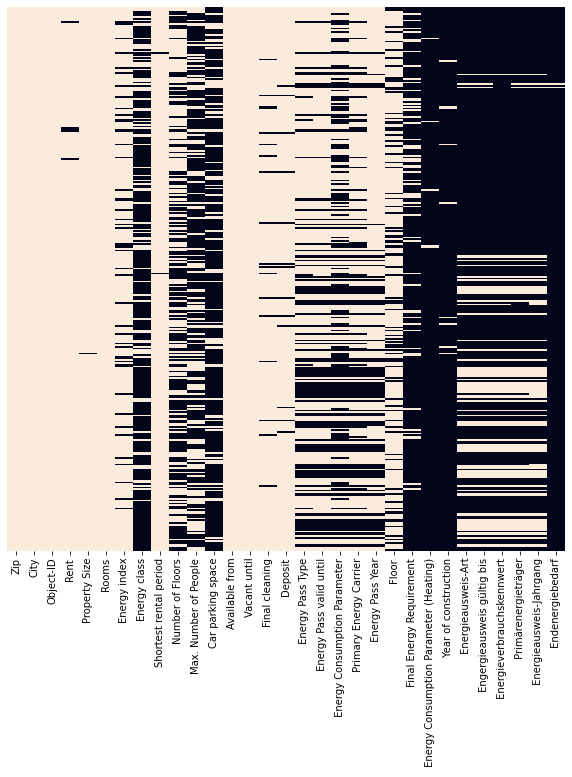

In [37]:
def vis_null(zeit):
    zeit_null = zeit.isnull()
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(~zeit_null, cbar=False, yticklabels=False, ax=ax)

vis_null(zeit)

It seems that the last columns have the most null values. Including the last 6 columns which are in German. Let's get rid of those first.

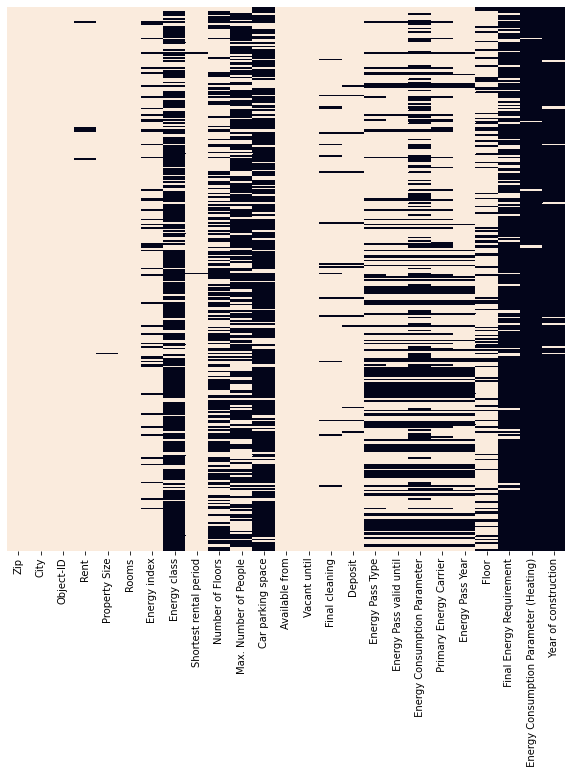

In [38]:
zeit = zeit.drop(zeit.columns[-6:], axis=1)
vis_null(zeit)

We have two columns which look similar: **Energy Consumption Parameter** and **Energy Consumption Parameter (Heating)** Let's investigate the rows where the latter is null and when it isn't null.

In [39]:
display(zeit.loc[~zeit[' Energy Consumption Parameter (Heating)'].isnull(),[' Energy Consumption Parameter', ' Energy Consumption Parameter (Heating)']].head(10))

,Energy Consumption Parameter,Energy Consumption Parameter (Heating)
19,NaN,"84,59 kWh/(m²*a)"
70,NaN,"84,59 kWh/(m²*a)"
112,NaN,"84,59 kWh/(m²*a)"
146,NaN,"84,59 kWh/(m²*a)"
147,NaN,"84,59 kWh/(m²*a)"


In [40]:
display(zeit.loc[zeit[' Energy Consumption Parameter (Heating)'].isnull(),[' Energy Consumption Parameter', ' Energy Consumption Parameter (Heating)']].head(10))

,Energy Consumption Parameter,Energy Consumption Parameter (Heating)
0,"98,45 kWh/(m²*a)",NaN
1,"98,45 kWh/(m²*a)",NaN
2,"98,45 kWh/(m²*a)",NaN
3,"189,00 kWh/(m²*a)",NaN
4,NaN,NaN
5,"128,00 kWh/(m²*a)",NaN
6,"144,00 kWh/(m²*a)",NaN
7,"159,00 kWh/(m²*a)",NaN
8,NaN,NaN
9,NaN,NaN


It seems like the two columns complement each other, let's combine them under one column.

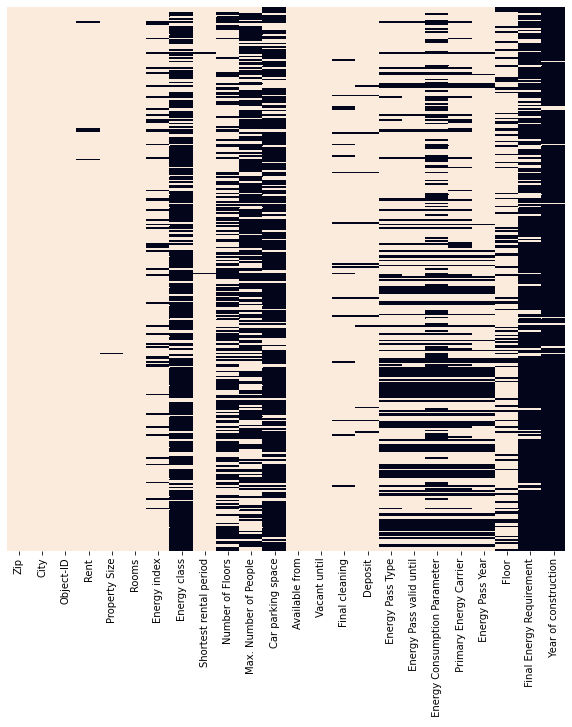

In [41]:
zeit[' Energy Consumption Parameter'] = zeit[' Energy Consumption Parameter'].mask(~zeit[' Energy Consumption Parameter (Heating)'].isnull(), zeit[' Energy Consumption Parameter (Heating)'])
zeit = zeit.drop(' Energy Consumption Parameter (Heating)', axis=1)
vis_null(zeit)

#### Removing Rows

Let's remove the obvious ones: Duplicates.

In [42]:
print('Before: '+str(zeit.shape))
zeit = zeit.drop_duplicates()
print('After: '+str(zeit.shape))

Before: (333, 24)
After: (332, 24)


### Transforming Data

#### Transforming Columns

We can notice that the column names are not consistent, some have extra spaces at the beginning, some have capitalized first letters, and some have none. Let's fix all that.

In [43]:
zeit.columns

Index(['Zip', 'City', 'Object-ID', 'Rent', 'Property Size', 'Rooms',
       'Energy index', 'Energy class', 'Shortest rental period',
       'Number of Floors', 'Max. Number of People', 'Car parking space',
       'Available from', 'Vacant until', 'Final cleaning', 'Deposit',
       ' Energy Pass Type', ' Energy Pass valid until',
       ' Energy Consumption Parameter', ' Primary Energy Carrier',
       ' Energy Pass Year', 'Floor', ' Final Energy Requirement',
       ' Year of construction'],
      dtype='object')

In [44]:
cols = zeit.columns
newcols={}
for i in cols:
    newi=i.strip()
    newi = newi.title()
    newcols[i]=newi
zeit.rename(columns = newcols, inplace = True)

zeit.columns

Index(['Zip', 'City', 'Object-Id', 'Rent', 'Property Size', 'Rooms',
       'Energy Index', 'Energy Class', 'Shortest Rental Period',
       'Number Of Floors', 'Max. Number Of People', 'Car Parking Space',
       'Available From', 'Vacant Until', 'Final Cleaning', 'Deposit',
       'Energy Pass Type', 'Energy Pass Valid Until',
       'Energy Consumption Parameter', 'Primary Energy Carrier',
       'Energy Pass Year', 'Floor', 'Final Energy Requirement',
       'Year Of Construction'],
      dtype='object')

Let's order it up a bit to make it more representative.

In [45]:
zeit = zeit[['Object-Id', 'City', 'Zip', 'Rent', 'Shortest Rental Period', 'Available From', 'Vacant Until',
      'Property Size', 'Rooms', 'Floor', 'Number Of Floors', 'Max. Number Of People', 'Deposit', 
      'Final Cleaning', 'Car Parking Space', 'Year Of Construction',  'Energy Index', 'Energy Pass Type',
      'Energy Pass Year', 'Energy Pass Valid Until', 'Energy Consumption Parameter', 'Primary Energy Carrier',
      'Energy Class', 'Final Energy Requirement']]
zeit.head(1)

,Object-Id,City,Zip,Rent,Shortest Rental Period,Available From,Vacant Until,Property Size,Rooms,Floor,...,Car Parking Space,Year Of Construction,Energy Index,Energy Pass Type,Energy Pass Year,Energy Pass Valid Until,Energy Consumption Parameter,Primary Energy Carrier,Energy Class,Final Energy Requirement
0,18416,Cologne,50931,"890 € per month (incl. VAT 5%), plus electrici...",3 Mon.,immediately,Not limited,"26,00 m2",1,NaN,...,NaN,NaN,98.45 kWh/m²a,Consumption,as from may 2014,13.05.2029,"98,45 kWh/(m²*a)",Gas,C,NaN


#### Transforming Rows

In [46]:
zeit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 0 to 332
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Object-Id                     332 non-null    int64  
 1   City                          332 non-null    object 
 2   Zip                           332 non-null    int64  
 3   Rent                          327 non-null    object 
 4   Shortest Rental Period        330 non-null    object 
 5   Available From                332 non-null    object 
 6   Vacant Until                  332 non-null    object 
 7   Property Size                 331 non-null    object 
 8   Rooms                         332 non-null    int64  
 9   Floor                         249 non-null    object 
 10  Number Of Floors              169 non-null    float64
 11  Max. Number Of People         126 non-null    float64
 12  Deposit                       319 non-null    object 
 13  Final

In [47]:
pd.set_option('display.max_columns', None)
zeit.describe(include="all")

,Object-Id,City,Zip,Rent,Shortest Rental Period,Available From,Vacant Until,Property Size,Rooms,Floor,Number Of Floors,Max. Number Of People,Deposit,Final Cleaning,Car Parking Space,Year Of Construction,Energy Index,Energy Pass Type,Energy Pass Year,Energy Pass Valid Until,Energy Consumption Parameter,Primary Energy Carrier,Energy Class,Final Energy Requirement
count,332.000000,332,332.000000,327,330,332,332,331,332.000000,249,169.000000,126.000000,319,314,73,9.000000,284,227,248,232,162,217,78,54
unique,NaN,26,NaN,202,6,41,8,71,NaN,17,NaN,NaN,27,1,1,NaN,121,2,4,55,87,4,9,42
top,NaN,Cologne,NaN,"990 € per month, plus electricity, incl. heating",3 Mon.,immediately,Not limited,"35,00 m2",NaN,Ground floor,NaN,NaN,2 Monthly rents,Varies depending on effort,yes,NaN,206.00 kWh/m²a,Consumption,before 2014,30.09.2021,"206,00 kWh/(m²*a)",Gas,C,"101,00 kWh/(m²*a)"
freq,NaN,220,NaN,9,214,225,324,23,NaN,53,NaN,NaN,133,314,73,NaN,35,171,180,162,10,144,21,4
mean,18036.590361,NaN,50476.072289,NaN,NaN,NaN,NaN,NaN,1.629518,NaN,4.816568,2.579365,NaN,NaN,NaN,1969.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13599.205498,NaN,2284.308114,NaN,NaN,NaN,NaN,NaN,0.915510,NaN,4.674725,1.509189,NaN,NaN,NaN,20.575741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,10001.000000,NaN,40789.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1935.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,13277.000000,NaN,50670.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,3.000000,2.000000,NaN,NaN,NaN,1957.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,16896.000000,NaN,50676.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,4.000000,2.000000,NaN,NaN,NaN,1965.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,18412.500000,NaN,50996.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,5.000000,3.000000,NaN,NaN,NaN,1988.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's start by converting the supposedly numeric columns to a numeric dtype:
- **Rent**

a tricky one, as we might need the additional information.


- **Available From, Vacant Until, Energy Pass Year, Energy Pass Valid Until**

to be transformed and converted to date.


- **Shortest Rental Period, Property Size, Deposit, Energy Index, Energy Consumption Parameter, Final Energy Requirement**

to be transformed and converted to float.

Let's inspect the **Rent** column first.

In [48]:
pd.set_option('display.max_rows', None)
display(zeit['Rent'].head(50))

0     890 € per month (incl. VAT 5%), plus electrici...
2     890 € per month (incl. VAT 5%), plus electrici...
3     930 € per month, incl. electricity, incl. heating
4     1.650 € per month, incl. electricity, incl. he...
5      990 € per month, plus electricity, incl. heating
6     1.480 € per month, incl. electricity, incl. he...
7      965 € per month, plus electricity, incl. heating
8     915 € per month, incl. electricity, incl. heating
9                                                   NaN
10    1.100 € per month, incl. electricity, incl. he...
11     900 € per month, plus electricity, incl. heating
12    1.100 € per month, plus electricity, incl. hea...
13    1.490 € per month, incl. electricity, incl. he...
14    1.190 € per month (incl. VAT 5%), incl. electr...
15    1.800 € per month, incl. electricity, incl. he...
16    1.640 € per month, incl. electricity, incl. he...
17     720 € per month, plus electricity, incl. heating
18    970 € per month (incl. VAT 5%), incl. elec

After inspection, it seems like there are two types of data, disregarding the numerical data. A regular monthly fee, and a monthly fee including VAT 5%.

There are few ways we can solve this:
- **Alternative 1** excluding the value-added tax from these monthly fees.
- **Alternative 2** including the value-added tax to the other regular monthly fees, by making the assumption it is 5%.
- **Alternative 3** adding a second column for value-added tax inclusions.

Alternative 1 will make the visualizations consistent and accurate, and implies no new assumptions.
Alternative 2 implies making an assumption that the universal VAT percentage is 5%, which can be wrong.
Alternative 3 will create some extra work for us in the visualization step, as we will need to take the VAT percentage out of the monthly fees.

Let's go with number 1.


In [49]:
x = zeit['Rent'].str.replace('.','')
a = [str(i) for i in x]

rent = []
for i in a:
    p = re.compile("(\d+) ")
    result = p.search(i)
    if result != None:
        if 'VAT' in i:
            rent.append(float(result.group(1))- (0.05*float(result.group(1))))
        else: rent.append(float(result.group(1)))
    else:
        rent.append(float(0))

In [50]:
zeit['Rent']= rent
display(zeit['Rent'].head(50))

0      845.50
2      845.50
3      930.00
4     1650.00
5      990.00
6     1480.00
7      965.00
8      915.00
9        0.00
10    1100.00
11     900.00
12    1100.00
13    1490.00
14    1130.50
15    1800.00
16    1640.00
17     720.00
18     921.50
19     990.00
20    1282.50
21    1092.50
22     590.00
23    1050.00
24    1130.50
25    1600.00
26    1225.50
27    1299.00
28    1777.00
29     960.00
30     845.50
31     890.00
32    1080.00
33     945.00
34     950.00
35     817.00
36    2350.00
37    1350.00
38    1190.00
39     690.00
40     915.00
41    2382.60
42    1290.00
43    2150.00
44     940.50
45    2650.00
46    1650.00
47    2695.00
48     901.55
49    2300.00
50    1500.00
Name: Rent, dtype: float64

Let's now deal with the dates: **Available From, Vacant Until, Energy Pass Year, Energy Pass Valid Until**

In [51]:
zeit[['Available From', 'Vacant Until', 'Energy Pass Year', 'Energy Pass Valid Until']].head(20)

,Available From,Vacant Until,Energy Pass Year,Energy Pass Valid Until
0,immediately,Not limited,as from may 2014,13.05.2029
2,immediately,Not limited,as from may 2014,13.05.2029
3,20.10.2020,Not limited,before 2014,30.09.2021
4,01.07.2021,Not limited,before 2014,30.09.2020
5,immediately,Not limited,before 2014,30.09.2021
6,01.11.2020,Not limited,before 2014,30.09.2021
7,01.11.2020,Not limited,before 2014,30.09.2021
8,01.12.2020,Not limited,as from may 2014,27.04.2029
9,immediately,Not limited,not required,NaN
10,immediately,Not limited,as from may 2014,13.05.2028


3 of these columns have similar date formats, but different exception values. We can still make a general function that deals with the dates given the exceptions values.

The `to_date()` function:
    
- Takes the list `l` to be inspected.
- Takes a list of exceptional values `excep`.
- Take a replacement value `repl` for exceptional values.
- Returns an updated list of `dates`.

In [52]:
def to_date (l, excep, repl):
    dates=[]
    for i in l:
        if i in excep:
            d = repl
        elif i==None:
            d=None
        else:
            dr=dt.datetime.strptime(i,"%d.%m.%Y")
            d=dr.strftime("%d/%m/%Y")
        dates.append(d)
    return dates

Let's start running the function.

In [53]:
print(zeit['Available From'].isnull().value_counts())
zeit['Available From'].value_counts()

False    332
Name: Available From, dtype: int64


immediately    225
01.11.2020      25
01.01.2021       8
01.12.2020       7
31.12.2020       6
15.10.2020       5
11.11.2020       5
15.11.2020       4
15.12.2020       3
25.10.2020       3
31.10.2020       3
30.11.2020       3
01.03.2021       2
12.12.2020       2
01.07.2021       2
02.01.2021       2
01.02.2021       2
08.10.2020       2
01.06.2021       1
28.02.2021       1
16.10.2020       1
30.10.2020       1
13.03.2021       1
14.03.2021       1
26.08.2021       1
14.09.2021       1
15.03.2021       1
21.10.2020       1
02.02.2021       1
07.11.2020       1
20.10.2020       1
01.01.2033       1
23.12.2020       1
26.10.2020       1
31.01.2021       1
05.11.2020       1
26.07.2021       1
16.01.2021       1
01.05.2021       1
01.09.2021       1
20.11.2020       1
Name: Available From, dtype: int64

We can safely assume that 'immediately' means today's date which is October the 7th, 2020. Let's get our new list.

In [54]:
available = to_date(zeit['Available From'],['immediately'],'07/10/2020')
available[:50]

['07/10/2020',
 '07/10/2020',
 '20/10/2020',
 '01/07/2021',
 '07/10/2020',
 '01/11/2020',
 '01/11/2020',
 '01/12/2020',
 '07/10/2020',
 '07/10/2020',
 '01/11/2020',
 '01/11/2020',
 '07/10/2020',
 '07/10/2020',
 '01/02/2021',
 '07/10/2020',
 '28/02/2021',
 '07/10/2020',
 '07/10/2020',
 '07/10/2020',
 '07/10/2020',
 '01/05/2021',
 '01/09/2021',
 '07/10/2020',
 '15/10/2020',
 '07/10/2020',
 '01/03/2021',
 '15/11/2020',
 '07/10/2020',
 '31/12/2020',
 '01/11/2020',
 '01/01/2021',
 '07/10/2020',
 '07/10/2020',
 '31/12/2020',
 '07/10/2020',
 '07/10/2020',
 '07/10/2020',
 '12/12/2020',
 '07/10/2020',
 '07/10/2020',
 '07/10/2020',
 '07/10/2020',
 '07/10/2020',
 '01/11/2020',
 '01/12/2020',
 '07/10/2020',
 '07/10/2020',
 '07/10/2020',
 '07/10/2020']

In [55]:
print(zeit['Vacant Until'].isnull().value_counts())
zeit['Vacant Until'].value_counts()

False    332
Name: Vacant Until, dtype: int64


Not limited    324
31.12.2020       2
01.12.2020       1
01.10.2020       1
30.09.2021       1
30.10.2021       1
30.11.2020       1
01.05.2020       1
Name: Vacant Until, dtype: int64

Let's replace 'Not limited' by a very far date

In [56]:
vacant = to_date(zeit['Vacant Until'],['Not limited'], '01/01/2100')
vacant[:20]

['01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100',
 '01/01/2100']

In [57]:
print(zeit['Energy Pass Valid Until'].isnull().value_counts())
zeit['Energy Pass Valid Until'].value_counts()

False    232
True     100
Name: Energy Pass Valid Until, dtype: int64


30.09.2021    162
04.11.2027      6
13.05.2029      5
30.09.2020      3
29.04.2024      2
06.05.2024      2
04.10.2028      2
24.07.2025      2
06.10.2018      2
27.04.2029      1
25.02.2029      1
18.09.2018      1
10.02.2029      1
22.05.2027      1
23.05.2029      1
19.07.2028      1
20.02.2025      1
15.02.2018      1
26.02.2026      1
05.03.2020      1
12.12.2027      1
12.06.2028      1
27.12.2027      1
24.09.2028      1
31.07.2019      1
16.07.2029      1
10.04.2029      1
04.01.2019      1
04.06.2028      1
12.09.2028      1
17.05.2030      1
07.01.2029      1
01.09.2020      1
01.08.2028      1
14.04.2024      1
23.04.2029      1
03.06.2028      1
13.05.2028      1
26.09.2028      1
22.07.2029      1
13.09.2021      1
06.06.2028      1
21.05.2028      1
09.08.2019      1
08.10.2028      1
29.10.2029      1
18.12.2027      1
15.07.2029      1
16.02.2029      1
28.08.2028      1
01.03.2018      1
26.06.2021      1
05.12.2026      1
14.06.2030      1
10.09.2028      1
Name: Ener

In this case, we have some null values. The good news are, we don't have any other exceptions. So whenever we have a null value. We will leave like that.

The good thing about `None` is that it mostly abides to all types. So our columns will still be of dtype datetime even with the null values.

In [58]:
zeit['Energy Pass Valid Until']=zeit['Energy Pass Valid Until'].astype(str)
energy = to_date(zeit['Energy Pass Valid Until'],['nan'],'nan')
energy[:50]

['13/05/2029',
 '13/05/2029',
 '30/09/2021',
 '30/09/2020',
 '30/09/2021',
 '30/09/2021',
 '30/09/2021',
 '27/04/2029',
 'nan',
 '13/05/2028',
 '10/09/2028',
 '01/03/2018',
 '30/09/2021',
 '15/02/2018',
 '30/09/2021',
 '30/09/2021',
 '30/09/2021',
 '30/09/2021',
 '04/11/2027',
 '06/05/2024',
 '06/05/2024',
 '30/09/2021',
 '30/09/2021',
 '13/05/2029',
 '30/09/2021',
 '30/09/2021',
 '17/05/2030',
 'nan',
 '30/09/2021',
 '13/05/2029',
 '29/04/2024',
 '12/12/2027',
 '22/07/2029',
 '27/12/2027',
 '13/05/2029',
 '22/05/2027',
 'nan',
 '04/06/2028',
 '31/07/2019',
 'nan',
 'nan',
 '30/09/2021',
 '30/09/2021',
 '12/09/2028',
 '10/02/2029',
 '30/09/2020',
 'nan',
 'nan',
 'nan',
 '04/10/2028']

Now for the **Energy Pass Year**

In [59]:
print(zeit['Energy Pass Year'].isnull().value_counts())
zeit['Energy Pass Year'].value_counts()

False    248
True      84
Name: Energy Pass Year, dtype: int64


before 2014         180
as from may 2014     52
not required         14
not available         2
Name: Energy Pass Year, dtype: int64

It seems like we have 4 types of values, which it makes it easier to handle manually.
Looking at this [article](https://www.trotec-blog.com/en/trotec/what-is-an-energy-pass/), by Trotec Blog, it seems that: "As of January 1 2009, any house that is sold or let in Germany must under new legislation have an Energy Pass. So if you are planning on selling your house or letting out your property in the near future, then you have to count on being asked to provide legitimate proof that your house, flat or apartment conforms to EnEV 2009 guidelines in the form of the new Energy Pass."

This is helpful in distinguishing between 3 cases, that are important to me, the consumer:
- **0** The apartment, must have, but has **no** Energy Pass.
- **1** The apartment **doesn't require** an Energy Pass.
- **2** The apartment has an Energy Pass.

Accordingly, instead of using dates as planned, we will replace these values by an integer based on the aforementioned cases:
- **before 2014** 2013
- **as from may 2014** 2014
- **not required** 1
- **not available** 0


In [60]:
pas=[]
zeit['Energy Pass Year']=zeit['Energy Pass Year'].astype(str)
for i in zeit['Energy Pass Year']:
    if 'before 2014' in i:
        d= 2013
    elif 'as from may 2014' in i:
        d= 2014
    elif 'not required' in i:
        d= 1
    elif 'not available' in i:
        d= 0
    elif i=='nan':
        d= None
    pas.append(d)

pas[:50]

[2014,
 2014,
 2013,
 2013,
 2013,
 2013,
 2013,
 2014,
 1,
 2014,
 2014,
 2013,
 2013,
 2013,
 2013,
 2013,
 2013,
 2013,
 2014,
 2014,
 2014,
 2013,
 2013,
 2014,
 2013,
 2013,
 2014,
 None,
 2013,
 2014,
 2013,
 2014,
 2014,
 2014,
 2014,
 2014,
 1,
 2014,
 2013,
 1,
 None,
 2013,
 2013,
 2014,
 2014,
 2013,
 None,
 None,
 None,
 2014]

Let's assign our news lists!

In [61]:
zeit['Energy Pass Valid Until']=energy
zeit['Vacant Until'] = vacant
zeit['Available From'] = available
zeit['Energy Pass Year'] = pas

zeit[['Energy Pass Valid Until','Vacant Until','Available From','Energy Pass Year']].head(20)

,Energy Pass Valid Until,Vacant Until,Available From,Energy Pass Year
0,13/05/2029,01/01/2100,07/10/2020,2014.0
2,13/05/2029,01/01/2100,07/10/2020,2014.0
3,30/09/2021,01/01/2100,20/10/2020,2013.0
4,30/09/2020,01/01/2100,01/07/2021,2013.0
5,30/09/2021,01/01/2100,07/10/2020,2013.0
6,30/09/2021,01/01/2100,01/11/2020,2013.0
7,30/09/2021,01/01/2100,01/11/2020,2013.0
8,27/04/2029,01/01/2100,01/12/2020,2014.0
9,nan,01/01/2100,07/10/2020,1.0
10,13/05/2028,01/01/2100,07/10/2020,2014.0


Now, let's check out the rest **Shortest Rental Period, Property Size, Deposit, Energy Index, Energy Consumption Parameter, Final Energy Requirement**

In [62]:
print(zeit[['Shortest Rental Period', 'Property Size', 'Deposit', 'Energy Index', 'Energy Consumption Parameter', 'Final Energy Requirement']].info())
zeit[['Shortest Rental Period', 'Property Size', 'Deposit', 'Energy Index', 'Energy Consumption Parameter', 'Final Energy Requirement']].head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 0 to 332
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Shortest Rental Period        330 non-null    object
 1   Property Size                 331 non-null    object
 2   Deposit                       319 non-null    object
 3   Energy Index                  284 non-null    object
 4   Energy Consumption Parameter  162 non-null    object
 5   Final Energy Requirement      54 non-null     object
dtypes: object(6)
memory usage: 18.2+ KB
None


,Shortest Rental Period,Property Size,Deposit,Energy Index,Energy Consumption Parameter,Final Energy Requirement
0,3 Mon.,"26,00 m2",1-2 monthly rent,98.45 kWh/m²a,"98,45 kWh/(m²*a)",NaN
2,3 Mon.,"25,00 m2",1-2 Monthly rent,98.45 kWh/m²a,"98,45 kWh/(m²*a)",NaN
3,3 Mon.,"28,00 m2",1-2 Monthly rents,189.00 kWh/m²a,"189,00 kWh/(m²*a)",NaN
4,3 Mon.,"75,00 m2",2 Monthly rents,211.00 kWh/m²a,NaN,"211,00 kWh/(m²*a)"
5,3 Mon.,"35,00 m2",2 Monthly rents,128.00 kWh/m²a,"128,00 kWh/(m²*a)",NaN
6,3 Mon.,"55,00 m2",1 monthly rent,144.00 kWh/m²a,"144,00 kWh/(m²*a)",NaN
7,3 Mon.,"30,00 m2",2 monthly rents,159.00 kWh/m²a,"159,00 kWh/(m²*a)",NaN
8,3 Mon.,"37,00 m2",1-2 Monthly rents,144.00 kWh/m²a,NaN,"144,00 kWh/(m²*a)"
9,3 Mon.,"35,00 m2",monthly rent 2,NaN,NaN,NaN
10,3 Mon.,"34,00 m2",1-2 Monthly rents,NaN,NaN,NaN


The process should be clear:
- extract the numbers
- throw out the strings
- change the columns names to represent the strings

Let's create a function that makes our life easier.

The `to_float()` function:
    
- Takes the list `l` to be inspected.
- Takes a list of exceptional values `excep` to watch for.
- Returns a list extracted float values `vals`.

In [63]:
def to_float (l, excep):
    vals=[]
    l = [str(k) for k in l]
    for i in l:
        if i in excep or i==None:
            v=None
        else:
            result=re.findall('\d+[,.-]*\d*', i)
            if result!=[]: v=result[0].replace(",",".")
            else: v=None
        vals.append(v)
    return vals

<img src="Images/0_3FC7jjO8u6NnVMVZ.jpg" alt="Drawing" style="width: 500px;">

Can't always relate.

In [64]:
for i in ['Shortest Rental Period', 'Property Size', 'Deposit', 'Energy Index', 'Energy Consumption Parameter', 'Final Energy Requirement']:
    newl = to_float(zeit[i],['nan'])
    zeit[i] = newl

How neat is that?

In [65]:
zeit[['Shortest Rental Period', 'Property Size', 'Deposit', 'Energy Index', 'Energy Consumption Parameter', 'Final Energy Requirement']].head(20)

,Shortest Rental Period,Property Size,Deposit,Energy Index,Energy Consumption Parameter,Final Energy Requirement
0,3,26.00,1-2,98.45,98.45,None
2,3,25.00,1-2,98.45,98.45,None
3,3,28.00,1-2,189.00,189.00,None
4,3,75.00,2,211.00,None,211.00
5,3,35.00,2,128.00,128.00,None
6,3,55.00,1,144.00,144.00,None
7,3,30.00,2,159.00,159.00,None
8,3,37.00,1-2,144.00,None,144.00
9,3,35.00,2,None,None,None
10,3,34.00,1-2,None,None,None


One more thing. Columns names!

In [66]:
rename = {'Rent' : 'Monthly Rent by €'
          ,'Shortest Rental Period':'Shortest Rental Period By Months'
          ,'Property Size': 'Property Size By m²'
          , 'Deposit': 'Deposit By Monthly Rents'
          , 'Energy Index' : 'Energy Index By kWh/m²a'
          , 'Energy Consumption Parameter': 'Energy Consumption Parameter By kWh/m²a'
          , 'Final Energy Requirement':'Final Energy Requirement By kWh/m²a'}
zeit.rename(rename, axis=1, inplace =True)

Now we're talking!

In [67]:
zeit.head(20)

,Object-Id,City,Zip,Monthly Rent by €,Shortest Rental Period By Months,Available From,Vacant Until,Property Size By m²,Rooms,Floor,Number Of Floors,Max. Number Of People,Deposit By Monthly Rents,Final Cleaning,Car Parking Space,Year Of Construction,Energy Index By kWh/m²a,Energy Pass Type,Energy Pass Year,Energy Pass Valid Until,Energy Consumption Parameter By kWh/m²a,Primary Energy Carrier,Energy Class,Final Energy Requirement By kWh/m²a
0,18416,Cologne,50931,845.5,3,07/10/2020,01/01/2100,26.00,1,NaN,4.0,2.0,1-2,Varies depending on effort,NaN,NaN,98.45,Consumption,2014.0,13/05/2029,98.45,Gas,C,None
2,18414,Cologne,50931,845.5,3,07/10/2020,01/01/2100,25.00,1,NaN,4.0,2.0,1-2,Varies depending on effort,NaN,NaN,98.45,Consumption,2014.0,13/05/2029,98.45,Gas,C,None
3,18856,Cologne,50672,930.0,3,20/10/2020,01/01/2100,28.00,1,4,NaN,2.0,1-2,Varies depending on effort,NaN,NaN,189.00,Consumption,2013.0,30/09/2021,189.00,Gas,NaN,None
4,18394,Cologne,50827,1650.0,3,01/07/2021,01/01/2100,75.00,3,2,NaN,NaN,2,Varies depending on effort,yes,NaN,211.00,Demand,2013.0,30/09/2020,None,Gas,NaN,211.00
5,18507,Bonn,53121,990.0,3,07/10/2020,01/01/2100,35.00,1,Ground floor,3.0,NaN,2,Varies depending on effort,NaN,NaN,128.00,Consumption,2013.0,30/09/2021,128.00,Gas,NaN,None
6,17460,Cologne,50674,1480.0,3,01/11/2020,01/01/2100,55.00,2,3,NaN,NaN,1,Varies depending on effort,NaN,NaN,144.00,Consumption,2013.0,30/09/2021,144.00,Gas,E,None
7,13003,Cologne,50674,965.0,3,01/11/2020,01/01/2100,30.00,1,4,NaN,NaN,2,Varies depending on effort,NaN,NaN,159.00,Consumption,2013.0,30/09/2021,159.00,Gas,NaN,None
8,18567,Bonn,53175,915.0,3,01/12/2020,01/01/2100,37.00,2,Ground floor,NaN,1.0,1-2,Varies depending on effort,NaN,NaN,144.00,Demand,2014.0,27/04/2029,None,Gas,E,144.00
9,81068,Bonn,53115,0.0,3,07/10/2020,01/01/2100,35.00,1,Ground floor,NaN,NaN,2,Varies depending on effort,NaN,NaN,None,NaN,1.0,nan,None,NaN,NaN,None
10,19172,Cologne,50735,1100.0,3,07/10/2020,01/01/2100,34.00,1,34,45.0,2.0,1-2,Varies depending on effort,yes,NaN,None,Consumption,2014.0,13/05/2028,None,Long-distance Heating,E,None


### Dealing with Missing Data

We did fill a lot of missing data along the way. But let's check our heatmap friend again to see our progress.

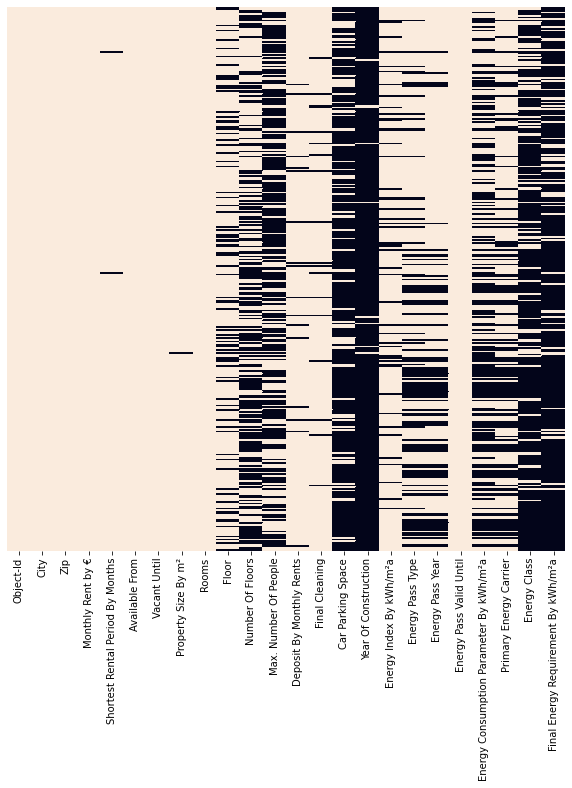

In [68]:
vis_null(zeit)

Let's tackle the obvious ones

In [69]:
zeit['Car Parking Space'].head(50)

0     NaN
2     NaN
3     NaN
4     yes
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    yes
11    yes
12    yes
13    yes
14    NaN
15    NaN
16    NaN
17    yes
18    NaN
19    NaN
20    yes
21    yes
22    NaN
23    yes
24    NaN
25    yes
26    NaN
27    NaN
28    NaN
29    NaN
30    NaN
31    NaN
32    yes
33    NaN
34    NaN
35    NaN
36    NaN
37    yes
38    NaN
39    NaN
40    NaN
41    NaN
42    NaN
43    yes
44    NaN
45    yes
46    yes
47    yes
48    yes
49    yes
50    NaN
Name: Car Parking Space, dtype: object

In [70]:
car=[]
for i in zeit['Car Parking Space']:
    if i!='yes':
        car.append('no')
    else:
        car.append('yes')
zeit['Car Parking Space'] = car
zeit['Car Parking Space'].head(50)

0      no
2      no
3      no
4     yes
5      no
6      no
7      no
8      no
9      no
10    yes
11    yes
12    yes
13    yes
14     no
15     no
16     no
17    yes
18     no
19     no
20    yes
21    yes
22     no
23    yes
24     no
25    yes
26     no
27     no
28     no
29     no
30     no
31     no
32    yes
33     no
34     no
35     no
36     no
37    yes
38     no
39     no
40     no
41     no
42     no
43    yes
44     no
45    yes
46    yes
47    yes
48    yes
49    yes
50     no
Name: Car Parking Space, dtype: object

Then let's drop the ones with too many missing values, that it doesn't make sense to use them for our analysis.

In [71]:
zeit=zeit.drop(['Energy Class','Final Energy Requirement By kWh/m²a','Year Of Construction'], axis =1)

Let's also drop the **Max. Number Of People** column since there is only one person making the decision, me.

In [72]:
zeit=zeit.drop(['Max. Number Of People'], axis =1)

Much better.

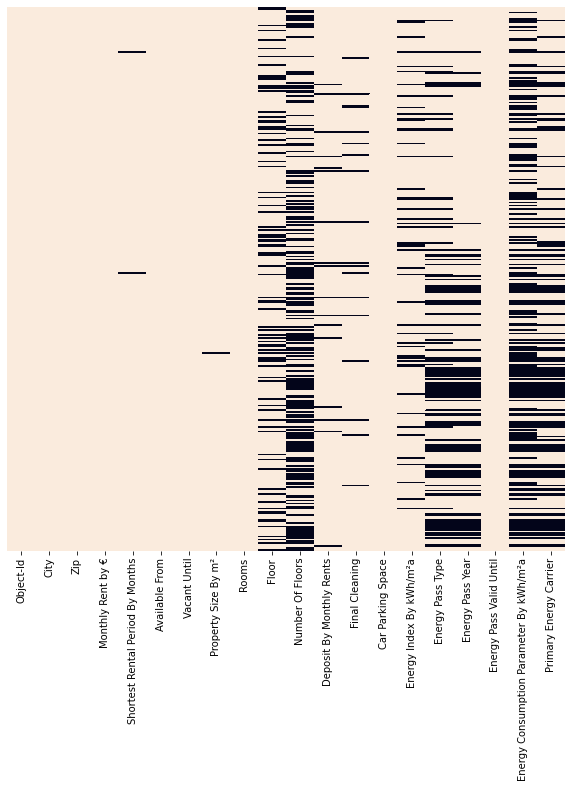

In [73]:
vis_null(zeit)

One final look!

In [74]:
zeit.head(20)

,Object-Id,City,Zip,Monthly Rent by €,Shortest Rental Period By Months,Available From,Vacant Until,Property Size By m²,Rooms,Floor,Number Of Floors,Deposit By Monthly Rents,Final Cleaning,Car Parking Space,Energy Index By kWh/m²a,Energy Pass Type,Energy Pass Year,Energy Pass Valid Until,Energy Consumption Parameter By kWh/m²a,Primary Energy Carrier
0,18416,Cologne,50931,845.5,3,07/10/2020,01/01/2100,26.00,1,NaN,4.0,1-2,Varies depending on effort,no,98.45,Consumption,2014.0,13/05/2029,98.45,Gas
2,18414,Cologne,50931,845.5,3,07/10/2020,01/01/2100,25.00,1,NaN,4.0,1-2,Varies depending on effort,no,98.45,Consumption,2014.0,13/05/2029,98.45,Gas
3,18856,Cologne,50672,930.0,3,20/10/2020,01/01/2100,28.00,1,4,NaN,1-2,Varies depending on effort,no,189.00,Consumption,2013.0,30/09/2021,189.00,Gas
4,18394,Cologne,50827,1650.0,3,01/07/2021,01/01/2100,75.00,3,2,NaN,2,Varies depending on effort,yes,211.00,Demand,2013.0,30/09/2020,None,Gas
5,18507,Bonn,53121,990.0,3,07/10/2020,01/01/2100,35.00,1,Ground floor,3.0,2,Varies depending on effort,no,128.00,Consumption,2013.0,30/09/2021,128.00,Gas
6,17460,Cologne,50674,1480.0,3,01/11/2020,01/01/2100,55.00,2,3,NaN,1,Varies depending on effort,no,144.00,Consumption,2013.0,30/09/2021,144.00,Gas
7,13003,Cologne,50674,965.0,3,01/11/2020,01/01/2100,30.00,1,4,NaN,2,Varies depending on effort,no,159.00,Consumption,2013.0,30/09/2021,159.00,Gas
8,18567,Bonn,53175,915.0,3,01/12/2020,01/01/2100,37.00,2,Ground floor,NaN,1-2,Varies depending on effort,no,144.00,Demand,2014.0,27/04/2029,None,Gas
9,81068,Bonn,53115,0.0,3,07/10/2020,01/01/2100,35.00,1,Ground floor,NaN,2,Varies depending on effort,no,None,NaN,1.0,nan,None,NaN
10,19172,Cologne,50735,1100.0,3,07/10/2020,01/01/2100,34.00,1,34,45.0,1-2,Varies depending on effort,yes,None,Consumption,2014.0,13/05/2028,None,Long-distance Heating


It is entirely possible to further clean the table, by filling null values with suitable replacements using **imputation**. Although that doesn't make a big impact, since we got most of the work needed to make our analysis and visualizations done.

Let's store our clean version!

In [75]:
zeit.to_csv('cleandf1.csv', index=False)

## Data Analysis & Visualization

In [76]:
clean = pd.read_csv('cleandf1.csv')
clean.head(20)

,Object-Id,City,Zip,Monthly Rent by €,Shortest Rental Period By Months,Available From,Vacant Until,Property Size By m²,Rooms,Floor,Number Of Floors,Deposit By Monthly Rents,Final Cleaning,Car Parking Space,Energy Index By kWh/m²a,Energy Pass Type,Energy Pass Year,Energy Pass Valid Until,Energy Consumption Parameter By kWh/m²a,Primary Energy Carrier
0,18416,Cologne,50931,845.5,3.0,07/10/2020,01/01/2100,26.0,1,NaN,4.0,1-2,Varies depending on effort,no,98.45,Consumption,2014.0,13/05/2029,98.45,Gas
1,18414,Cologne,50931,845.5,3.0,07/10/2020,01/01/2100,25.0,1,NaN,4.0,1-2,Varies depending on effort,no,98.45,Consumption,2014.0,13/05/2029,98.45,Gas
2,18856,Cologne,50672,930.0,3.0,20/10/2020,01/01/2100,28.0,1,4,NaN,1-2,Varies depending on effort,no,189.00,Consumption,2013.0,30/09/2021,189.00,Gas
3,18394,Cologne,50827,1650.0,3.0,01/07/2021,01/01/2100,75.0,3,2,NaN,2,Varies depending on effort,yes,211.00,Demand,2013.0,30/09/2020,NaN,Gas
4,18507,Bonn,53121,990.0,3.0,07/10/2020,01/01/2100,35.0,1,Ground floor,3.0,2,Varies depending on effort,no,128.00,Consumption,2013.0,30/09/2021,128.00,Gas
5,17460,Cologne,50674,1480.0,3.0,01/11/2020,01/01/2100,55.0,2,3,NaN,1,Varies depending on effort,no,144.00,Consumption,2013.0,30/09/2021,144.00,Gas
6,13003,Cologne,50674,965.0,3.0,01/11/2020,01/01/2100,30.0,1,4,NaN,2,Varies depending on effort,no,159.00,Consumption,2013.0,30/09/2021,159.00,Gas
7,18567,Bonn,53175,915.0,3.0,01/12/2020,01/01/2100,37.0,2,Ground floor,NaN,1-2,Varies depending on effort,no,144.00,Demand,2014.0,27/04/2029,NaN,Gas
8,81068,Bonn,53115,0.0,3.0,07/10/2020,01/01/2100,35.0,1,Ground floor,NaN,2,Varies depending on effort,no,NaN,NaN,1.0,NaN,NaN,NaN
9,19172,Cologne,50735,1100.0,3.0,07/10/2020,01/01/2100,34.0,1,34,45.0,1-2,Varies depending on effort,yes,NaN,Consumption,2014.0,13/05/2028,NaN,Long-distance Heating


In [77]:
clean.describe(include="all")

,Object-Id,City,Zip,Monthly Rent by €,Shortest Rental Period By Months,Available From,Vacant Until,Property Size By m²,Rooms,Floor,Number Of Floors,Deposit By Monthly Rents,Final Cleaning,Car Parking Space,Energy Index By kWh/m²a,Energy Pass Type,Energy Pass Year,Energy Pass Valid Until,Energy Consumption Parameter By kWh/m²a,Primary Energy Carrier
count,332.000000,332,332.000000,332.000000,330.000000,332,332,331.000000,332.000000,249,169.000000,315,314,332,284.000000,227,248.000000,232,162.000000,217
unique,NaN,26,NaN,NaN,NaN,41,8,NaN,NaN,17,NaN,5,1,2,NaN,2,NaN,55,NaN,4
top,NaN,Cologne,NaN,NaN,NaN,07/10/2020,01/01/2100,NaN,NaN,Ground floor,NaN,2,Varies depending on effort,no,NaN,Consumption,NaN,30/09/2021,NaN,Gas
freq,NaN,220,NaN,NaN,NaN,225,324,NaN,NaN,53,NaN,185,314,259,NaN,171,NaN,162,NaN,144
mean,18036.590361,NaN,50476.072289,1188.651807,2.833333,NaN,NaN,46.271903,1.629518,NaN,4.816568,NaN,NaN,NaN,156.719789,NaN,1883.395161,NaN,153.026111,NaN
std,13599.205498,NaN,2284.308114,524.598457,0.787118,NaN,NaN,24.874809,0.915510,NaN,4.674725,NaN,NaN,NaN,55.406501,NaN,495.373933,NaN,48.040046,NaN
min,10001.000000,NaN,40789.000000,0.000000,2.000000,NaN,NaN,12.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,12.000000,NaN,0.000000,NaN,12.000000,NaN
25%,13277.000000,NaN,50670.000000,857.500000,2.000000,NaN,NaN,30.000000,1.000000,NaN,3.000000,NaN,NaN,NaN,115.800000,NaN,2013.000000,NaN,119.250000,NaN
50%,16896.000000,NaN,50676.000000,1115.250000,3.000000,NaN,NaN,38.000000,1.000000,NaN,4.000000,NaN,NaN,NaN,156.000000,NaN,2013.000000,NaN,148.500000,NaN
75%,18412.500000,NaN,50996.000000,1401.500000,3.000000,NaN,NaN,57.000000,2.000000,NaN,5.000000,NaN,NaN,NaN,206.000000,NaN,2013.000000,NaN,181.750000,NaN


Let's visualize the rental offers on a map!

First, let's convert our zip codes into longitude and latitude coordinates.

In [78]:
locs={}
long=[]
lat=[]

for a,b in clean.iterrows():
    nomi = pgeocode.Nominatim('de')
    info = nomi.query_postal_code(b[2])
    locs[b[1]]=(info[10],info[9])
    long.append(info[10])
    lat.append(info[9])

Then, we'll be using the **plz-gebiete.shp** dataset that can be found in [suche-postleitzahl](https://www.suche-postleitzahl.org/downloads) to visualize the shape and districts of Germany.

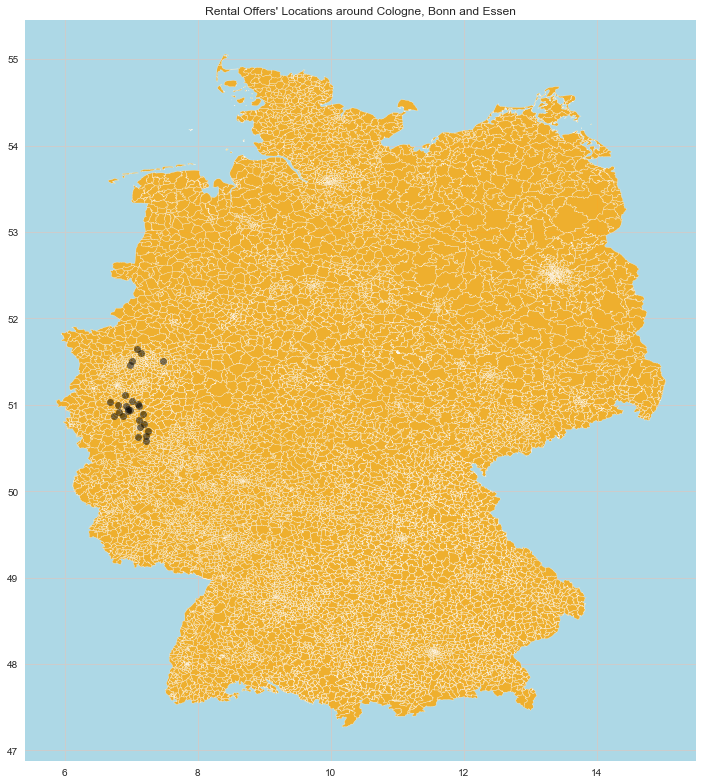

In [113]:
Fig1, ax1 = plt.subplots(figsize = (16, 11))
plt.style.use('seaborn')
plz_shape_df = gpd.read_file('plz-gebiete.shp', dtype={'plz': str})
plz_shape_df.plot(ax=ax1, color='orange', alpha=0.8)
ax1.set(title="Rental Offers' Locations around Cologne, Bonn and Essen", aspect=1.3, facecolor='lightblue')

for c in locs.keys():
    ax1.plot(locs[c][0], locs[c][1], marker='o',c='black', alpha=0.5)
plt.tight_layout()
plt.show()

Let's zoom in a litte bit, to see the Rhine river!

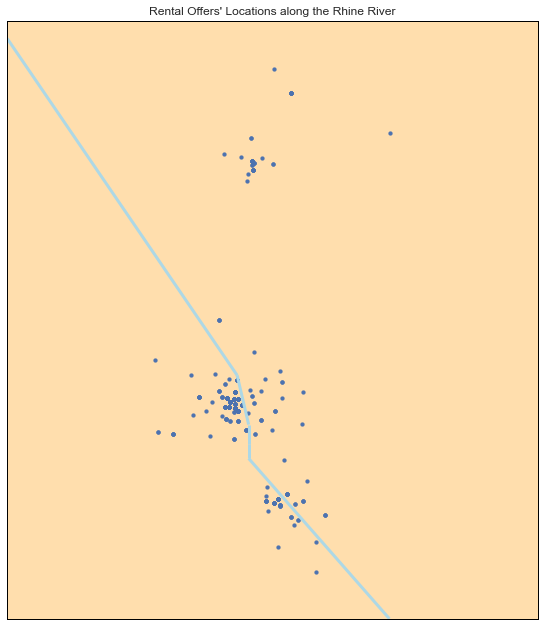

In [87]:
Fig2, ax2 = plt.subplots(figsize = (16, 11))
plt.style.use('seaborn')

mp = Basemap(projection= "merc", resolution = 'c'
             , llcrnrlat= min(lat)-0.1
             , urcrnrlat= max(lat)+0.1
             , llcrnrlon= min(long)-0.5
             , urcrnrlon= max(long)+0.5)

x,y = mp(long,lat)

mp.scatter(x,y, s=15, zorder=2)
mp.drawcoastlines(color='#6D5F47', linewidth=.4) 
mp.drawmapboundary(fill_color='navajowhite')
mp.drawrivers(color='lightblue', linewidth=3)
ax2.set(title="Rental Offers' Locations along the Rhine River")

plt.show()

Everything seems to be correct, no out of order locations, which means no out of order zip codes.

### Finding Patterns

Now let's tackle the most bugging questions.

#### Which city has relatively higher prices?

The `pivot()` function:
    
- Takes the `values`column name.
- Takes the `index` column name.
- Returns a dataframe `df` grouping values by the index.

The `barplot()` function:
    
- Takes the last `df`, `values` and the index `ind`.
- Takes the `title` of the plot.
- Takes the figure `size`.
- Displays a horizontal barplot of `values` by `ind`.

In [88]:
def pivot (values, index):
    df = clean.pivot_table(values, index, margins = True)
    df = df.sort_values(values, ascending = False)
    return df

def barplot(df, values, ind, title, size):
    sns.set_style('whitegrid')
    fig = plt.subplots(figsize=size)
    ax = sns.barplot(x=values,
                     y=df.index,
                     data=df,
                     orient='h',
                     palette='pastel')
    n=0
    for a,b in df.iterrows():
        ax.text(x=b[values],
                y=n,
                s=int(b[values]),
                fontsize=12,
                horizontalalignment='left',
                verticalalignment='center')
        n+=1
    
    ax.tick_params(axis='x', labelsize=10, labelbottom=False)
    ax.tick_params(axis='y', labelsize=10, bottom='off')
    ax.set_title(title, fontsize=16)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)


    ax.set_ylabel(ind, fontsize=12)
    ax.set_xlabel(values, fontsize=12)
    plt.tight_layout()

    plt.show()

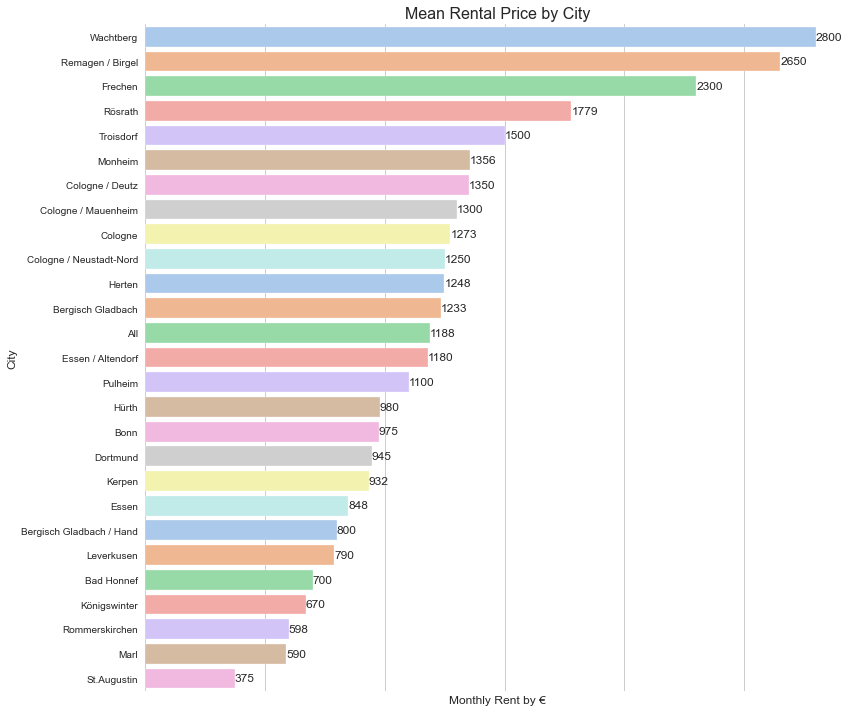

In [89]:
df = pivot('Monthly Rent by €','City')
barplot(df, 'Monthly Rent by €', 'City', 'Mean Rental Price by City',(12,10))

Since my budget doesn't allow more than 1500 euros per month, it seems like Rösrath, Frechen, Remagen/Birgel, and Wachtberg aren't the best places I would want to look in.

However let's make sure even more of our interpretations.

The `boxplot()` function:
    
- Takes the `values`column name.
- Takes the `ind` column name.
- Takes a dataframe `df` grouping `values` by `ind`.
- Takes the `title` of the plot.
- Takes the figure `size`.
- Takes the rotation degree `rot`.
- Takes x label size `lsize`.
- Prints a boxplot of `values` by `ind`.

In [90]:
def boxplot(df, values, ind, title, size, rot,lsize):
    sns.set_style('whitegrid')
    fig = plt.subplots(figsize=size)
    ax = sns.boxplot(x=ind,
                     y=values,
                     data=clean,
                     showfliers=False, order=df.index, palette='pastel')
    
    ax.tick_params(axis='x', labelrotation=rot, labelsize=lsize)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title(title, fontsize=16)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)


    ax.set_ylabel(values, fontsize=12)
    ax.set_xlabel(ind, fontsize=12)
    plt.tight_layout()

    plt.show()

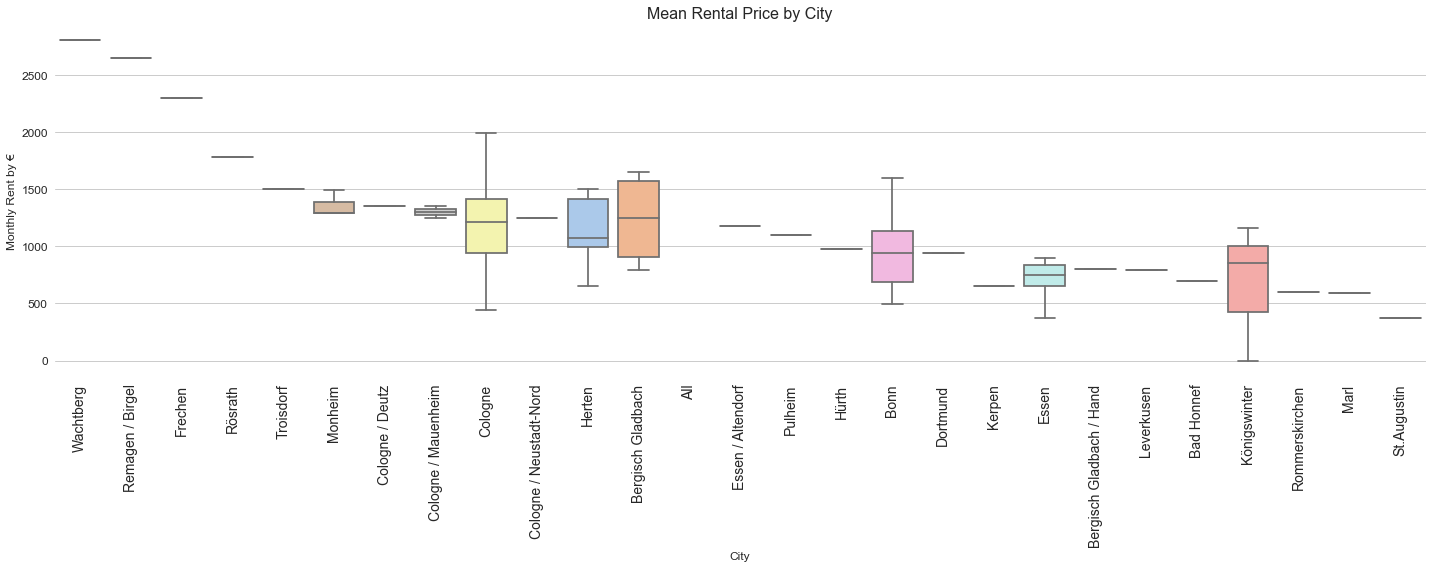

In [91]:
df = pivot('Monthly Rent by €','City')
boxplot(df, 'Monthly Rent by €', 'City', 'Mean Rental Price by City',(20,8),90,14)

The boxplot is useful in showing us not only the mean of the groups, but also how many values are there and where do they stand.

It seems here that the cities we were about to rule out are only represented by one rental offer. Therefore our interpretation is not totally correct. We can not judge the groups represented by a small number of values.

A more accurate interpretation would be that Cologne is more expensive on average than Bonn. And that Bonn is a little more expensive on average than Essen.

#### Does the number of rooms affect the rental price?

The `pivotv()` function:
    
- Takes the `values`column name.
- Takes the `index` column name.
- Takes a boolean value to decide whether to `sort`.
- Returns a dataframe `df` grouping values by the index.

The `barplotv()` function:
    
- Takes the last `df`, `values` and the index `ind`.
- Takes the `title` of the plot.
- Takes the figure `size`.
- Displays a vertical barplot of `values` by `ind`.

In [92]:
def pivotv (values, index, sort):
    df = clean.pivot_table(values, index)
    if sort==True: df = df.sort_values(values, ascending = True)
    return df

def barplotv(df, values, ind, title, size):
    sns.set_style('white')
    fig = plt.subplots(figsize=size)
    ax = sns.barplot(x=ind,
                     y=values,
                     data=clean,
                     palette ='pastel',order=df.index, ci=None)

    n=0
    for a,b in df.iterrows():
        ax.text(y=b[values]+20,
                x=n,
                s=int(b[values]),
                fontsize=12,
                horizontalalignment='center',
                verticalalignment='baseline')
        n+=1
    
    ax.tick_params(axis='x', labelsize=10)
    ax.set_title(title, fontsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.yaxis.set_visible(False)
    ax.set_xlabel(ind, fontsize=12)

    plt.tight_layout()
    plt.show()



In [93]:
def quickbarsv(values, index, title, size, sort):
    df = pivotv (values, index, sort)
    barplotv(df, values, index, title, size)

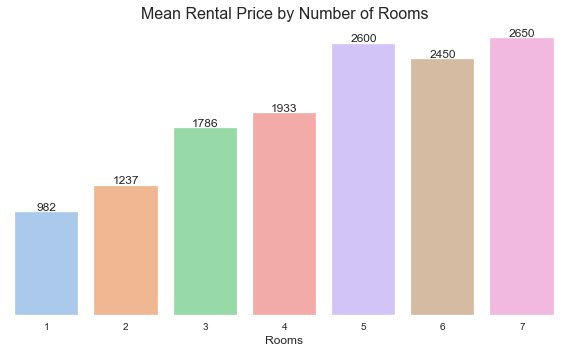

In [94]:
quickbarsv('Monthly Rent by €', 'Rooms', 'Mean Rental Price by Number of Rooms',(8,5), False)

In [97]:
def quickbox(values, index, title, size, sort,rot,lsize):
    df = pivotv (values, index, sort)
    boxplot(df, values, index, title, size,rot,lsize)

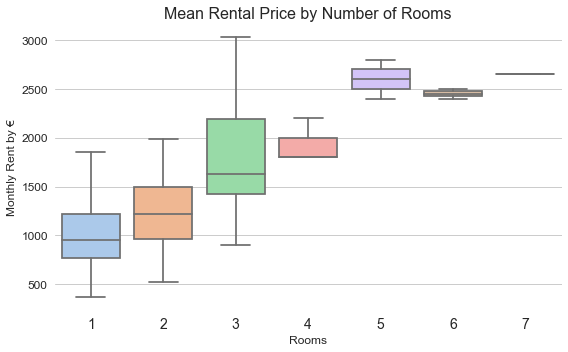

In [98]:
quickbox('Monthly Rent by €','Rooms','Mean Rental Price by '+'Number of Rooms',(8,5), False,0,14)

It seems like the boxplot further confirms that the rental price increases with the increase of the number of rooms. Especially for an interval of 1 to 5 rooms. This makes sense in real life as well, as a large number of rooms require more property size, furniture and maintenance, which adds up on the total of costs endured.

#### What about the type of the primary energy carrier?

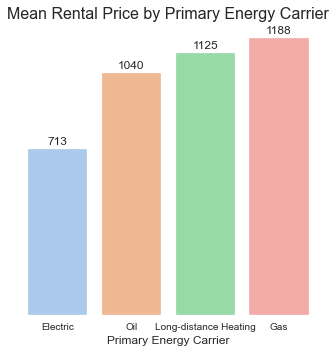

In [99]:
quickbarsv('Monthly Rent by €', 'Primary Energy Carrier', 'Mean Rental Price by '+'Primary Energy Carrier', (5,5), True)

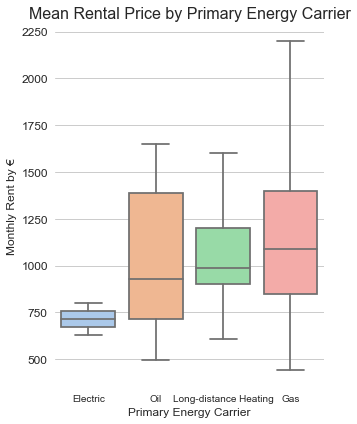

In [100]:
quickbox('Monthly Rent by €','Primary Energy Carrier','Mean Rental Price by '+'Primary Energy Carrier',(5,6), True,0,10)

A couple others useful visualizations show us that having an electric primary energy carrier significantly helps reducing the average price of the rental offer, especially compared to gas and long-distance heating carriers

#### And the property size?

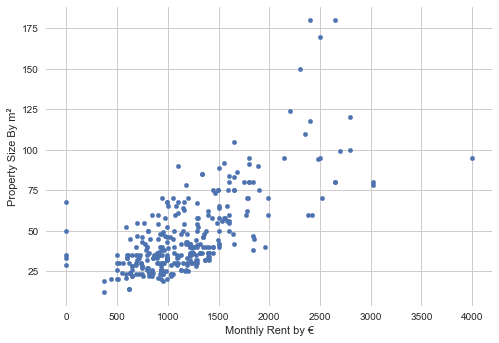

In [101]:
clean.plot('Monthly Rent by €','Property Size By m²', kind='scatter') 

In [102]:
clean[['Monthly Rent by €','Property Size By m²']].corr()

,Monthly Rent by €,Property Size By m²
Monthly Rent by €,1.000000,0.701416
Property Size By m²,0.701416,1.000000


The correlation coefficient almost reaches 0.7 which is the on the verge of being considered a strong correlation. We can conclude that the rental price is indeed affected by the size of the property, the same way it is affected by the number of rooms.

Can we conclude from this that the property size and the number of rooms are also correlated?

#### Anything else?

Let's use the correlation table to find any interesting patterns we might have missed.

In [103]:
clean.corr()

,Object-Id,Zip,Monthly Rent by €,Shortest Rental Period By Months,Property Size By m²,Rooms,Number Of Floors,Energy Index By kWh/m²a,Energy Pass Year,Energy Consumption Parameter By kWh/m²a
Object-Id,1.000000,0.090481,0.000763,0.079706,0.110056,0.079838,0.018905,-0.156736,-0.201600,-0.192951
Zip,0.090481,1.000000,0.063648,0.064231,-0.018409,-0.002476,-0.068472,-0.067966,-0.133845,-0.071678
Monthly Rent by €,0.000763,0.063648,1.000000,-0.183229,0.701416,0.605750,-0.052688,0.115283,0.125249,-0.027838
Shortest Rental Period By Months,0.079706,0.064231,-0.183229,1.000000,0.074518,0.119584,-0.026149,-0.189938,-0.055814,-0.094329
Property Size By m²,0.110056,-0.018409,0.701416,0.074518,1.000000,0.871595,-0.083784,-0.050717,-0.029748,-0.152785
Rooms,0.079838,-0.002476,0.605750,0.119584,0.871595,1.000000,-0.137728,-0.081750,-0.053505,-0.136550
Number Of Floors,0.018905,-0.068472,-0.052688,-0.026149,-0.083784,-0.137728,1.000000,0.030717,0.102754,0.073078
Energy Index By kWh/m²a,-0.156736,-0.067966,0.115283,-0.189938,-0.050717,-0.081750,0.030717,1.000000,-0.183594,1.000000
Energy Pass Year,-0.201600,-0.133845,0.125249,-0.055814,-0.029748,-0.053505,0.102754,-0.183594,1.000000,-0.352998
Energy Consumption Parameter By kWh/m²a,-0.192951,-0.071678,-0.027838,-0.094329,-0.152785,-0.136550,0.073078,1.000000,-0.352998,1.000000


It seems like other than Rooms Vs Property Size By m², there isn't any other interesting patterns to dig into.

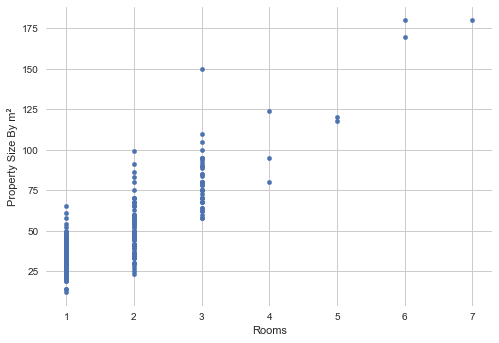

In [104]:
clean.plot('Rooms','Property Size By m²', kind='scatter') 

The correlation coefficient is around 0.65 which presents a moderate correlation. We can conclude that our assumption is correct. The number of rooms is actually moderately correlated to the size of the property.

### Ranking System

Although finding correlations and pattern matching are very important steps in data analysis projects. We will not spend much time on them, as they don't seem to be useful when we are trying to pick one choice out of all the 300 offers we got.

A better way to look at those offers, is by ranking them from the most suitable for us to the least. We will accomplish that by scoring them on different aspects. 

In [105]:
clean.columns

Index(['Object-Id', 'City', 'Zip', 'Monthly Rent by €',
       'Shortest Rental Period By Months', 'Available From', 'Vacant Until',
       'Property Size By m²', 'Rooms', 'Floor', 'Number Of Floors',
       'Deposit By Monthly Rents', 'Final Cleaning', 'Car Parking Space',
       'Energy Index By kWh/m²a', 'Energy Pass Type', 'Energy Pass Year',
       'Energy Pass Valid Until', 'Energy Consumption Parameter By kWh/m²a',
       'Primary Energy Carrier'],
      dtype='object')

In [106]:
factors = clean[['City'
    , 'Monthly Rent by €'
    ,'Shortest Rental Period By Months'
    , 'Available From'
    ,'Property Size By m²'
    , 'Rooms'
    , 'Number Of Floors'
    ,'Deposit By Monthly Rents'
    , 'Car Parking Space'
    ,'Energy Index By kWh/m²a']].copy()
factors.head(20)

,City,Monthly Rent by €,Shortest Rental Period By Months,Available From,Property Size By m²,Rooms,Number Of Floors,Deposit By Monthly Rents,Car Parking Space,Energy Index By kWh/m²a
0,Cologne,845.5,3.0,07/10/2020,26.0,1,4.0,1-2,no,98.45
1,Cologne,845.5,3.0,07/10/2020,25.0,1,4.0,1-2,no,98.45
2,Cologne,930.0,3.0,20/10/2020,28.0,1,NaN,1-2,no,189.00
3,Cologne,1650.0,3.0,01/07/2021,75.0,3,NaN,2,yes,211.00
4,Bonn,990.0,3.0,07/10/2020,35.0,1,3.0,2,no,128.00
5,Cologne,1480.0,3.0,01/11/2020,55.0,2,NaN,1,no,144.00
6,Cologne,965.0,3.0,01/11/2020,30.0,1,NaN,2,no,159.00
7,Bonn,915.0,3.0,01/12/2020,37.0,2,NaN,1-2,no,144.00
8,Bonn,0.0,3.0,07/10/2020,35.0,1,NaN,2,no,NaN
9,Cologne,1100.0,3.0,07/10/2020,34.0,1,45.0,1-2,yes,NaN


Let's first assign a number on a scale from 1 to 10 for each of these factors depending on their importance to us.

In [107]:
importance = {
    'City': 7
    , 'Monthly Rent by €': 10
    ,'Shortest Rental Period By Months':4
    , 'Available From':3
    ,'Property Size By m²':6
    , 'Rooms':5
    , 'Number Of Floors':4
    ,'Deposit By Monthly Rents':1
    , 'Car Parking Space':2
    ,'Energy Index By kWh/m²a':1
}

Then, let's assign to the factors, our best case scenarios.

In [108]:
best = {
    'City': 'Cologne'
    , 'Monthly Rent by €': (factors['Monthly Rent by €'],'min')
    ,'Shortest Rental Period By Months': (factors['Shortest Rental Period By Months'], 'min')
    , 'Available From': '06/10/2020'
    ,'Property Size By m²':(factors['Property Size By m²'], 'max')
    , 'Rooms': (factors['Rooms'], 'max')
    , 'Number Of Floors': (factors['Number Of Floors'], 'max')
    ,'Deposit By Monthly Rents':'1'
    , 'Car Parking Space':'yes'
    ,'Energy Index By kWh/m²a':(factors['Energy Index By kWh/m²a'],'max')
}

Using the `factors` and the `best` dictionaries, we will be able to assign a score to each rental offer, based on our preferences.

In [109]:
k=0
score=[]
for a,b in factors.iterrows():
    k+=1
    sub=[]
    for i in best:
        if b[i] == None or b[i]=='nan':
            sc=0
        elif str(b[i]) == best[i]:
            sc=importance[i]*10
        elif isinstance(best[i], str):
            sc=importance[i]*5
        elif best[i][1]=='min':
            sc= importance[i]*10*(1-(( b[i]-min(best[i][0]) ) / ( max(best[i][0]) - min(best[i][0]) )))
        elif best[i][1]=='max':
            sc=importance[i]*10*(1-(( max(best[i][0])-b[i] ) / ( max(best[i][0]) - min(best[i][0]) )))
        sub.append(sc)
        if k<6: print(str(i)+': '+str(b[i])+', Score: '+str(sc)+'/100')
    score.append(sub)
    if k<6: print('\n____________________________\n')

City: Cologne, Score: 70/100
Monthly Rent by €: 845.5, Score: 78.8625/100
Shortest Rental Period By Months: 3.0, Score: 30.0/100
Available From: 07/10/2020, Score: 15/100
Property Size By m²: 26.0, Score: 5.000000000000002/100
Rooms: 1, Score: 0.0/100
Number Of Floors: 4.0, Score: 2.7272727272727293/100
Deposit By Monthly Rents: 1-2, Score: 5/100
Car Parking Space: no, Score: 10/100
Energy Index By kWh/m²a: 98.45, Score: 2.1240786240786234/100

____________________________

City: Cologne, Score: 70/100
Monthly Rent by €: 845.5, Score: 78.8625/100
Shortest Rental Period By Months: 3.0, Score: 30.0/100
Available From: 07/10/2020, Score: 15/100
Property Size By m²: 25.0, Score: 4.64285714285714/100
Rooms: 1, Score: 0.0/100
Number Of Floors: 4.0, Score: 2.7272727272727293/100
Deposit By Monthly Rents: 1-2, Score: 5/100
Car Parking Space: no, Score: 10/100
Energy Index By kWh/m²a: 98.45, Score: 2.1240786240786234/100

____________________________

City: Cologne, Score: 70/100
Monthly Rent b

In [110]:
sc=0
winners=[]
for i in score:
    if sum(i)>sc:
        maxsc =sum(i)

k=0
for i in score:
    if sum(i)==maxsc:
        winners.append(clean.iloc[k])
    k+=1

In [111]:
winners

[Object-Id                                                       14545
 City                                                          Cologne
 Zip                                                             50676
 Monthly Rent by €                                              1225.5
 Shortest Rental Period By Months                                    2
 Available From                                             07/10/2020
 Vacant Until                                               01/01/2100
 Property Size By m²                                                30
 Rooms                                                               1
 Floor                                                               2
 Number Of Floors                                                    4
 Deposit By Monthly Rents                                          NaN
 Final Cleaning                             Varies depending on effort
 Car Parking Space                                                  no
 Energ

### Ladies and gents, we have a winner!

- In Cologne's city center
- A decent sized room, with balcony
- Reasonable price, including VAT
- Available immediately
- Allowing a short rental period
- And right beside McDonald's!

Let's follow the `Object-ID` to check the link of the website.

In [112]:
winner = 'https://www.zeitwohnen.de/en/furnished-apartments-'+str(winners[0]['City'])+'/rental-' + str(winners[0]['Object-Id'])
IFrame(winner, width=1000, height=1000)

<img src="Images/2020-10-07.png">

<img src="Images/2020-10-07 (1).png">

<img src="Images/2020-10-07 (2).png">

<img src="Images/2020-10-07 (3).png">

## Conclusion

**What did I accomplish?**

- I picked a [platform](https://www.zeitwohnen.de/en/) that lists a large number of furnished apartments around Cologne, Bonn, and Essen, in English.
- I started by sending requests to the website's API to receive its HTML file.
- I used the file to identify and gather the keys and values needed to build my dataset.
- I cleaned the dataset by removing irrelevant data, transforming data and dealing with missing data.
- I analyzed the dataset by answering multiple questions that helped me reveal patterns and make relationships between columns.
- I built a system that ranks the rental offers from most suitable to least, responding to my personal preferences.

**What did I learn?**
- Cologne is more expensive on average than Bonn. And so is Bonn compared to Essen.
- Rental prices are positively correlated to the properties' size and the number of rooms.
- The number of rooms is moderately correlated to the size of the property.
- Electric primary energy carriers reduce the average price of rental offers, compared to gas and long-distance heating carriers.
- Box plots can help us verify our assumptions by demonstrating the frequency of values in addition to their mean.
- Scatter plots and correlation tables are one of the easiest ways to reveal patterns among columns.
- The cleaning process is the longest and least enjoyable part of data analysis projects.


**How can I improve my project?**
- Look for another platform if needed to include more rows and more useful columns like ratings, reviews, etc.
- Find more patterns and make more insightful visualizations.
- Anything else? Feel free to hit me up at dazinesal@gmail.com or at [Linkedin](https://www.linkedin.com/in/dazinesal/) :)